In [4]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
%load_ext autoreload
%autoreload 2

In [4]:
class TestStat:
    def __init__(self, uf, oob_func, n_jobs=1):
        self.uf = uf
        self.fit_ = False
        
    def statistic(self, X, y):
        y = y.ravel()
        if not self.fit_:
            self.uf = self.uf.fit(X, y)
            if hasattr(self, "leaf_indices_"):
                del self.leaf_indices_
            self.fit_ = True
        if not hasattr(self, "leaf_indices_"):
            self.leaf_indices_ = []
            for tree, voter_indices in zip(self.uf.transformers_, self.uf.voter_indices_):
                self.leaf_indices_.append(tree.apply(X[voter_indices]))

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._refit_apply_oob(X, y)
        return H_Y - H_YX

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        for tree, leaf_indices, voter_indices in zip(self.uf.transformers_, self.leaf_indices_, self.uf.voter_indices_):
        # for tree_idx, (leaf_indices, voter_indices) in enumerate(zip(self.leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0
            # print(tree.tree_.value.shape)
            # print(leaf_indices)

            for leaf_id, yval in zip(leaf_indices, y[voter_indices]):
                tree.tree_.value[leaf_id][0, yval] += 1
                # posteriors[leaf_id,]

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[voter_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(entropy(posteriors, base=np.exp(1), axis=1))


In [6]:
def find_dim(sim):
    """Find dimension maximum for the simulation."""
    if sim not in SIMULATIONS.keys():
        raise ValueError("Invalid simulation")

    if sim in ["joint_normal", "sin_four_pi", "sin_sixteen_pi", "multiplicative_noise"]:
        dim = 10
    elif sim in ["multimodal_independence", "uncorrelated_bernoulli", "logarithmic"]:
        dim = 100
    elif sim in ["linear", "exponential", "cubic"]:
        dim = 1000
    elif sim in ["square", "diamond"]:
        dim = 40
    else:
        dim = 20

    return dim

def find_dim_range(dim):
    """Create list of dimension range to calculate power for."""
    if dim < 20:
        lim = 10
    else:
        lim = 20

    dim_range = list(range(int(dim / lim), dim + 1, int(dim / lim)))
    if int(dim / lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

In [6]:
def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat.statistic(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000, workers=1):
    """
    Calculate the p-value via permutation
    """
    # calculate observed test statistic
    stat = calc_stat.statistic(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in range(reps)])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)


    return stat, pvalue

In [7]:
POWER_REPS = 5

def estimate_power(sim, test):
    
    est_power = []
    dim_range = find_dim_range(find_dim(sim))
    for i in tqdm(dim_range):
        print("dimension " + str(i))
        print(sim)
    
        pvalues = []
        for _ in tqdm(range(POWER_REPS)): 
            x, y = rot_ksamp(sim, n=100, p=i, noise=True)
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            y = y.ravel()
            print(X.shape)
            print(y.shape)
            uf = UncertaintyForest(
                n_estimators=100,
                tree_construction_proportion=0.5,
                kappa=np.inf,
                honest_prior="ignore",
                max_features=1.0,
                n_jobs=-2,
            )
            uf = uf.fit(X, y)
            print('Fitted')

            ce = lambda x: entropy(x, axis=1, base=np.exp(1))
            obs_stat = TestStat(uf, ce)

            reps = 1000
            stat, pvalue = perm_test(obs_stat, X, y, reps=reps, workers=-2)
            print(pvalue)
            pvalues.append(pvalue)
            with open("./type_vs_attributes_test.csv", "w") as f:
                f.write(f"Test Statistic,p-value\n{stat},{pvalue}")
        num = 0
        for pval in pvalues: 
            if pval <= 0.05: 
                num += 1
        empirical_power = (1+num) / (1+POWER_REPS)
        est_power.append(empirical_power)
        
    print(est_power)
        
    
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}_vs_Dimension_HonestSampling_5_2.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power

In [10]:
for sim_name in tqdm(SIMULATIONS.keys()): 
    power = estimate_power(sim_name, "UF")

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

dimension 1
linear
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:51, 42.86s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<02:06, 42.16s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:30<01:39, 49.55s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:43<00:56, 56.81s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:52<00:00, 58.51s/it]

  5%|███▊                                                                            | 1/21 [04:52<1:37:31, 292.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 50
linear
(200, 51)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:54<03:38, 54.62s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:49<02:44, 54.67s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:49<01:52, 56.26s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:50<00:57, 57.70s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:44<00:00, 56.85s/it]

 10%|███████▌                                                                        | 2/21 [09:36<1:31:51, 290.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 100
linear
(200, 101)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:07<04:31, 67.92s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:21<03:28, 69.63s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:24<02:15, 67.70s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:39<01:09, 69.69s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:33<00:00, 78.68s/it]

 14%|███████████▍                                                                    | 3/21 [16:10<1:36:19, 321.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 150
linear
(200, 151)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:09<04:37, 69.32s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:04<03:14, 64.94s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:15<02:13, 66.79s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:13<01:04, 64.31s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:16<00:00, 63.30s/it]

 19%|███████████████▏                                                                | 4/21 [21:26<1:30:34, 319.69s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 200
linear
(200, 201)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:08<04:33, 68.28s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:23<03:30, 70.26s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:46<02:28, 74.14s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:47<01:10, 70.33s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 71.51s/it]

 24%|███████████████████                                                             | 5/21 [27:24<1:28:16, 331.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 250
linear
(200, 251)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:08<04:32, 68.16s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:58<04:02, 80.78s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:37<02:52, 86.32s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [06:19<01:30, 90.91s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:43<00:00, 92.75s/it]

 29%|██████████████████████▊                                                         | 6/21 [35:08<1:32:43, 370.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 300
linear
(200, 301)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:25<05:43, 85.88s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:58<04:23, 87.96s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:48<03:08, 94.40s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [06:00<01:27, 87.88s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:02<00:00, 84.41s/it]

 33%|██████████████████████████▋                                                     | 7/21 [42:10<1:30:07, 386.23s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 350
linear
(200, 351)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:46<03:06, 46.58s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:59<02:43, 54.35s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:12<02:36, 78.10s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [06:17<01:32, 92.23s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:58<00:00, 95.74s/it]

 38%|██████████████████████████████▍                                                 | 8/21 [50:08<1:29:41, 413.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 400
linear
(200, 401)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:13<04:53, 73.33s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:31<03:44, 74.86s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:49<02:31, 75.57s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [05:10<01:17, 77.41s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:05<00:00, 73.06s/it]

 43%|██████████████████████████████████▎                                             | 9/21 [56:14<1:19:52, 399.38s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 450
linear
(200, 451)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:11<04:46, 71.70s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:56<03:11, 63.72s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:51<02:02, 61.05s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:18<01:08, 68.72s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:18<00:00, 63.75s/it]

 48%|████████████████████████████████████▋                                        | 10/21 [1:01:32<1:08:47, 375.20s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 500
linear
(200, 501)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:50<03:23, 50.80s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:45<02:35, 51.99s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:39<01:44, 52.47s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:40<00:55, 55.14s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.66s/it]

 52%|█████████████████████████████████████████▍                                     | 11/21 [1:06:06<57:26, 344.64s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 550
linear
(200, 551)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:02<04:08, 62.08s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:03<03:05, 61.99s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:15<02:09, 64.90s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:04<01:00, 60.10s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:49<00:00, 57.96s/it]

 57%|█████████████████████████████████████████████▏                                 | 12/21 [1:10:56<49:13, 328.19s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 600
linear
(200, 601)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:46<03:04, 46.04s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:33<02:19, 46.41s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:30<01:39, 49.76s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:28<00:52, 52.16s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:48<00:00, 57.72s/it]

 62%|████████████████████████████████████████████████▉                              | 13/21 [1:15:44<42:10, 316.33s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 650
linear
(200, 651)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:29<05:58, 89.57s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:39<04:10, 83.63s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:38<02:32, 76.16s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [05:52<01:33, 93.77s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:08<00:00, 97.70s/it]

 67%|████████████████████████████████████████████████████▋                          | 14/21 [1:23:53<42:55, 367.99s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 700
linear
(200, 701)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:16<05:07, 76.87s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:24<03:41, 73.95s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:06<02:09, 64.57s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:50<00:58, 58.48s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:49<00:00, 57.92s/it]

 71%|████████████████████████████████████████████████████████▍                      | 15/21 [1:28:42<34:26, 344.48s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 750
linear
(200, 751)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:41<02:46, 41.51s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<02:05, 41.69s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:06<01:24, 42.05s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:50<00:42, 42.55s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:34<00:00, 42.81s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [1:32:16<25:26, 305.35s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 800
linear
(200, 801)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:44<02:59, 44.85s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:28<02:13, 44.51s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:00<01:21, 40.73s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:35<00:38, 38.97s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:05<00:00, 37.12s/it]

 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [1:35:22<17:57, 269.43s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 850
linear
(200, 851)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:03, 30.76s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:31, 30.61s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:01, 30.66s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.98s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.51s/it]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [1:38:00<11:47, 235.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 900
linear
(200, 901)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.86s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:30, 30.12s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:03, 31.79s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:31, 31.59s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.63s/it]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [1:40:38<07:05, 212.56s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 950
linear
(200, 951)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:58, 29.73s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:29, 29.92s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.45s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.69s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.66s/it]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [1:43:11<03:14, 194.80s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 1000
linear
(200, 1001)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:02, 30.67s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:32, 30.88s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:06, 33.22s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:11<00:32, 32.55s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.59s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
linear done
dimension 1
exponential
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:54, 28.60s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.61s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:56, 28.48s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:53<00:28, 28.37s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.39s/it]

  5%|███▉                                                                              | 1/21 [02:21<47:19, 141.97s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 50
exponential
(200, 51)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.86s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.83s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.93s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:59<00:30, 30.07s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.40s/it]

 10%|███████▊                                                                          | 2/21 [04:53<45:54, 144.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 100
exponential
(200, 101)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.03s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:28, 29.34s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:58, 29.02s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:28, 28.76s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.01s/it]

 14%|███████████▋                                                                      | 3/21 [07:19<43:30, 145.00s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 150
exponential
(200, 151)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:07, 31.85s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:32, 30.84s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:02, 31.05s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:19<00:36, 36.01s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.60s/it]

 19%|███████████████▌                                                                  | 4/21 [10:07<43:02, 151.91s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 200
exponential
(200, 201)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.89s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.21s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:56, 28.30s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.42s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.66s/it]

 24%|███████████████████▌                                                              | 5/21 [12:30<39:49, 149.34s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 250
exponential
(200, 251)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:31, 37.81s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:45, 35.11s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:06, 33.32s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:31, 31.67s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.38s/it]

 29%|███████████████████████▍                                                          | 6/21 [15:02<37:31, 150.11s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 300
exponential
(200, 301)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.75s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:40, 33.52s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:06, 33.42s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.21s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.93s/it]

 33%|███████████████████████████▎                                                      | 7/21 [17:41<35:41, 152.97s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 350
exponential
(200, 351)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.96s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:33, 31.09s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:01, 30.68s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:02<00:30, 30.34s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.32s/it]

 38%|███████████████████████████████▏                                                  | 8/21 [20:13<33:03, 152.57s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 400
exponential
(200, 401)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.88s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.95s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:57, 28.97s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.03s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.89s/it]

 43%|███████████████████████████████████▏                                              | 9/21 [22:38<30:01, 150.14s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 450
exponential
(200, 451)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.40s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.28s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.21s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.11s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.95s/it]

 48%|██████████████████████████████████████▌                                          | 10/21 [25:02<27:14, 148.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 500
exponential
(200, 501)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:54, 28.61s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.80s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.78s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.67s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.77s/it]

 52%|██████████████████████████████████████████▍                                      | 11/21 [27:26<24:31, 147.14s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 550
exponential
(200, 551)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:58, 29.65s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:28, 29.54s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.74s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:30, 30.75s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.77s/it]

 57%|██████████████████████████████████████████████▎                                  | 12/21 [30:00<22:22, 149.15s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 600
exponential
(200, 601)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.96s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.96s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.84s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.92s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.95s/it]

 62%|██████████████████████████████████████████████████▏                              | 13/21 [32:25<19:42, 147.83s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 650
exponential
(200, 651)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.21s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.39s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:56, 28.47s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:53<00:28, 28.34s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]

 67%|██████████████████████████████████████████████████████                           | 14/21 [34:46<17:01, 145.90s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 700
exponential
(200, 701)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.11s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.13s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.10s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.71s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]

 71%|█████████████████████████████████████████████████████████▊                       | 15/21 [37:09<14:30, 145.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 750
exponential
(200, 751)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.81s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.73s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<00:59, 29.97s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:59<00:29, 29.84s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.58s/it]

 76%|█████████████████████████████████████████████████████████████▋                   | 16/21 [39:37<12:09, 145.92s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 800
exponential
(200, 801)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.76s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.74s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.70s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.52s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.56s/it]

 81%|█████████████████████████████████████████████████████████████████▌               | 17/21 [42:00<09:39, 144.99s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 850
exponential
(200, 851)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.91s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.90s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.91s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.10s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.02s/it]

 86%|█████████████████████████████████████████████████████████████████████▍           | 18/21 [44:25<07:15, 145.02s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 900
exponential
(200, 901)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.02s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.11s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:56, 28.26s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:52<00:28, 28.12s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.61s/it]

 90%|█████████████████████████████████████████████████████████████████████████▎       | 19/21 [46:53<04:51, 145.94s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 950
exponential
(200, 951)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.98s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.98s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.05s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.26s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.96s/it]

 95%|█████████████████████████████████████████████████████████████████████████████▏   | 20/21 [49:23<02:27, 147.10s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 1000
exponential
(200, 1001)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.43s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.30s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.15s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.10s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.04s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
exponential done
dimension 1
cubic
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.14s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:26, 28.67s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:58, 29.04s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.93s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.60s/it]

  5%|███▉                                                                              | 1/21 [02:23<47:40, 143.01s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 50
cubic
(200, 51)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.11s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.05s/it]

0.001998001998001998
(200, 51)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.05s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.13s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.18s/it]

 10%|███████▊                                                                          | 2/21 [04:48<45:33, 143.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 100
cubic
(200, 101)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:54, 28.63s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.66s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.92s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.54s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.11s/it]

 14%|███████████▋                                                                      | 3/21 [07:24<44:12, 147.39s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 150
cubic
(200, 151)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.45s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:28, 29.45s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.30s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.21s/it]

0.000999000999000999
(200, 151)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.52s/it]

 19%|███████████████▌                                                                  | 4/21 [09:52<41:46, 147.45s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 200
cubic
(200, 201)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.43s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.32s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:58, 29.46s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.33s/it]

0.000999000999000999
(200, 201)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.56s/it]

 24%|███████████████████▌                                                              | 5/21 [12:19<39:21, 147.57s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 250
cubic
(200, 251)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:00, 30.02s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.81s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.54s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.65s/it]

0.000999000999000999
(200, 251)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.33s/it]

 29%|███████████████████████▍                                                          | 6/21 [14:46<36:49, 147.30s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 300
cubic
(200, 301)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.86s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.89s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.22s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.33s/it]

0.000999000999000999
(200, 301)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.05s/it]

 33%|███████████████████████████▎                                                      | 7/21 [17:16<34:34, 148.19s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 350
cubic
(200, 351)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.33s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.31s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:58, 29.36s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.34s/it]

0.000999000999000999
(200, 351)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.30s/it]

 38%|███████████████████████████████▏                                                  | 8/21 [19:43<31:59, 147.68s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 400
cubic
(200, 401)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.93s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.72s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.65s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.64s/it]

0.000999000999000999
(200, 401)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.75s/it]

 43%|███████████████████████████████████▏                                              | 9/21 [22:12<29:36, 148.00s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 450
cubic
(200, 451)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.36s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:28, 29.44s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:58, 29.36s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.36s/it]

0.000999000999000999
(200, 451)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.24s/it]

 48%|██████████████████████████████████████▌                                          | 10/21 [24:38<27:02, 147.46s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 500
cubic
(200, 501)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.79s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.81s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.02s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.24s/it]

0.000999000999000999
(200, 501)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.06s/it]

 52%|██████████████████████████████████████████▍                                      | 11/21 [27:08<24:43, 148.32s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 550
cubic
(200, 551)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.47s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.71s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:29<00:59, 29.70s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.59s/it]

0.000999000999000999
(200, 551)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.49s/it]

 57%|██████████████████████████████████████████████▎                                  | 12/21 [29:36<22:12, 148.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 600
cubic
(200, 601)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.24s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.27s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.56s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.62s/it]

0.000999000999000999
(200, 601)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.75s/it]

 62%|██████████████████████████████████████████████████▏                              | 13/21 [32:04<19:46, 148.28s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 650
cubic
(200, 651)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:41<02:46, 41.65s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:12<01:55, 38.45s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:11, 35.87s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:34, 34.08s/it]

0.000999000999000999
(200, 651)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.45s/it]

 67%|██████████████████████████████████████████████████████                           | 14/21 [34:47<17:47, 152.47s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 700
cubic
(200, 701)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.37s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:30, 30.07s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.18s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:09<00:32, 32.40s/it]

0.000999000999000999
(200, 701)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.69s/it]

 71%|█████████████████████████████████████████████████████████▊                       | 15/21 [37:25<15:25, 154.26s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 750
cubic
(200, 751)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.79s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:29, 29.93s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<00:59, 29.95s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.05s/it]

0.000999000999000999
(200, 751)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.00s/it]

 76%|█████████████████████████████████████████████████████████████▋                   | 16/21 [39:55<12:44, 153.00s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 800
cubic
(200, 801)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:00, 30.20s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.96s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.74s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.58s/it]

0.000999000999000999
(200, 801)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.53s/it]

 81%|█████████████████████████████████████████████████████████████████▌               | 17/21 [42:23<10:05, 151.40s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 850
cubic
(200, 851)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.33s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:28, 29.45s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:58, 29.35s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.49s/it]

0.000999000999000999
(200, 851)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.50s/it]

 86%|█████████████████████████████████████████████████████████████████████▍           | 18/21 [44:50<07:30, 150.25s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 900
cubic
(200, 901)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.49s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:28, 29.55s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:29<00:59, 29.79s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:31, 31.01s/it]

0.000999000999000999
(200, 901)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.53s/it]

 90%|█████████████████████████████████████████████████████████████████████████▎       | 19/21 [47:23<05:01, 150.97s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 950
cubic
(200, 951)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:58, 29.58s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:30, 30.05s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.18s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:01<00:30, 30.36s/it]

0.000999000999000999
(200, 951)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:32<00:00, 30.56s/it]

 95%|█████████████████████████████████████████████████████████████████████████████▏   | 20/21 [49:56<02:31, 151.53s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 1000
cubic
(200, 1001)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:01, 30.42s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:30, 30.15s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:29<00:59, 29.95s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:59<00:30, 30.09s/it]

0.000999000999000999
(200, 1001)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.89s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
cubic done
dimension 1
joint_normal
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.43s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:24, 28.16s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:56, 28.02s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:53<00:28, 28.43s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.34s/it]

 10%|████████▏                                                                         | 1/10 [02:21<21:15, 141.68s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
joint_normal
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:49, 27.48s/it]

0.7172827172827173
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:22, 27.58s/it]

0.000999000999000999
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:56, 28.21s/it]

0.07592407592407592
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.07s/it]

0.006993006993006993
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.19s/it]

 20%|████████████████▍                                                                 | 2/10 [04:47<19:03, 142.96s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.16983016983016982
dimension 3
joint_normal
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.89s/it]

0.1848151848151848
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.14s/it]

0.4065934065934066
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:02, 31.46s/it]

0.11188811188811189
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.25s/it]

0.02197802197802198
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.38s/it]

 30%|████████████████████████▌                                                         | 3/10 [07:24<17:10, 147.15s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.24575424575424576
dimension 4
joint_normal
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.56s/it]

0.0989010989010989
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:15<01:47, 35.79s/it]

0.002997002997002997
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:47<01:09, 34.56s/it]

0.04495504495504495
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:19<00:33, 33.64s/it]

0.01898101898101898
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.91s/it]

 40%|████████████████████████████████▊                                                 | 4/10 [10:14<15:23, 153.87s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.08191808191808192
dimension 5
joint_normal
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.56s/it]

0.008991008991008992
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:35, 31.88s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.66s/it]

0.01898101898101898
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.49s/it]

0.06693306693306693
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.38s/it]

 50%|█████████████████████████████████████████                                         | 5/10 [12:51<12:53, 154.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.003996003996003996
dimension 6
joint_normal
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.57s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:35, 31.72s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:09, 34.69s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:33, 33.74s/it]

0.004995004995004995
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.83s/it]

 60%|█████████████████████████████████████████████████▏                                | 6/10 [15:40<10:36, 159.11s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 7
joint_normal
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:05, 31.42s/it]

0.005994005994005994
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.26s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:02, 31.01s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.93s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 30.81s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [18:14<07:52, 157.60s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 8
joint_normal
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:03, 30.84s/it]

0.005994005994005994
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:32, 30.96s/it]

0.003996003996003996
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:01, 30.93s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.70s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.36s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:51<05:14, 157.36s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.002997002997002997
dimension 9
joint_normal
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:03, 30.95s/it]

0.001998001998001998
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:32, 30.96s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:01, 30.82s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:38, 38.13s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.60s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [23:59<02:46, 166.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
joint_normal
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:44<02:57, 44.41s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:22<02:07, 42.57s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:09<01:27, 43.90s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:53<00:43, 43.81s/it]

0.001998001998001998
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:36<00:00, 43.22s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.5, 0.3333333333333333, 0.6666666666666666, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0]
joint_normal done
dimension 1
step
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:49, 42.29s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:40<02:20, 46.95s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:22<01:30, 45.49s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:00<00:43, 43.31s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:38<00:00, 43.72s/it]

  5%|████                                                                            | 1/20 [03:38<1:09:14, 218.63s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
step
(200, 3)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:43, 40.92s/it]

0.005994005994005994
(200, 3)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:19<02:00, 40.12s/it]

0.1018981018981019
(200, 3)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:56<01:18, 39.29s/it]

0.16183816183816183
(200, 3)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:35<00:39, 39.05s/it]

0.002997002997002997
(200, 3)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:22<00:00, 40.46s/it]

 10%|████████                                                                        | 2/20 [07:00<1:04:07, 213.73s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.14185814185814186
dimension 3
step
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:50, 42.59s/it]

0.12687312687312688
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<02:06, 42.12s/it]

0.6603396603396603
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:07<01:25, 42.67s/it]

0.24675324675324675
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:47<00:41, 41.79s/it]

0.26673326673326675
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:26<00:00, 41.34s/it]

 15%|████████████▎                                                                     | 3/20 [10:27<59:57, 211.63s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.052947052947052944
dimension 4
step
(200, 5)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:44<02:59, 44.80s/it]

0.04695304695304695
(200, 5)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:10, 43.51s/it]

0.002997002997002997
(200, 5)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:05<01:24, 42.47s/it]

0.7802197802197802
(200, 5)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:47<00:42, 42.47s/it]

0.004995004995004995
(200, 5)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:29<00:00, 41.99s/it]

 20%|████████████████▍                                                                 | 4/20 [13:57<56:18, 211.13s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.27972027972027974
dimension 5
step
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:40, 40.03s/it]

0.057942057942057944
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:22<02:02, 40.90s/it]

0.12087912087912088
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:04<01:21, 40.97s/it]

0.03896103896103896
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:44<00:40, 40.93s/it]

0.08091908091908091
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:33<00:00, 42.64s/it]

 25%|████████████████████▌                                                             | 5/20 [17:30<52:56, 211.76s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.11388611388611389
dimension 6
step
(200, 7)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:51, 42.83s/it]

0.005994005994005994
(200, 7)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:26<02:08, 42.94s/it]

0.06993006993006994
(200, 7)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:18<01:31, 45.73s/it]

0.005994005994005994
(200, 7)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:58<00:44, 44.22s/it]

0.01998001998001998
(200, 7)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:39<00:00, 43.86s/it]

 30%|████████████████████████▌                                                         | 6/20 [21:10<49:56, 214.03s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 7
step
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:38, 39.50s/it]

0.052947052947052944
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:21<02:00, 40.30s/it]

0.001998001998001998
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:58<01:18, 39.16s/it]

0.013986013986013986
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:35<00:38, 38.70s/it]

0.058941058941058944
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.73s/it]

 35%|████████████████████████████▋                                                     | 7/20 [24:23<45:02, 207.92s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.061938061938061936
dimension 8
step
(200, 9)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:40, 40.01s/it]

0.000999000999000999
(200, 9)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:21<02:01, 40.35s/it]

0.057942057942057944
(200, 9)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:04<01:22, 41.26s/it]

0.011988011988011988
(200, 9)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:57<00:44, 44.72s/it]

0.007992007992007992
(200, 9)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:46<00:00, 45.29s/it]

 40%|████████████████████████████████▊                                                 | 8/20 [28:10<42:41, 213.48s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.04895104895104895
dimension 9
step
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:46<03:07, 46.76s/it]

0.007992007992007992
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:13, 44.48s/it]

0.023976023976023976
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:07<01:27, 43.63s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:48<00:42, 42.86s/it]

0.01998001998001998
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:32<00:00, 42.40s/it]

 45%|████████████████████████████████████▉                                             | 9/20 [31:42<39:03, 213.04s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.014985014985014986
dimension 10
step
(200, 11)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:37, 39.33s/it]

0.026973026973026972
(200, 11)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:57, 39.29s/it]

0.008991008991008992
(200, 11)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:58<01:19, 39.52s/it]

0.001998001998001998
(200, 11)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:40<00:40, 40.15s/it]

0.001998001998001998
(200, 11)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:21<00:00, 40.22s/it]

 50%|████████████████████████████████████████▌                                        | 10/20 [35:03<34:54, 209.46s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.02197802197802198
dimension 11
step
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:37, 39.48s/it]

0.01098901098901099
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:58, 39.38s/it]

0.001998001998001998
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:08<01:24, 42.38s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:45<00:40, 40.94s/it]

0.001998001998001998
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:25<00:00, 41.01s/it]

 55%|████████████████████████████████████████████▌                                    | 11/20 [38:28<31:13, 208.15s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 12
step
(200, 13)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:41<02:44, 41.08s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:20<02:01, 40.55s/it]

0.001998001998001998
(200, 13)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:58<01:19, 39.80s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:39<00:40, 40.13s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.80s/it]

 60%|████████████████████████████████████████████████▌                                | 12/20 [41:47<27:23, 205.41s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 13
step
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:37, 39.39s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:19<01:59, 39.75s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:57<01:18, 39.06s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:37<00:39, 39.50s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.55s/it]

 65%|████████████████████████████████████████████████████▋                            | 13/20 [45:05<23:41, 203.12s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.029970029970029972
dimension 14
step
(200, 15)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:27, 36.90s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:53, 37.72s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:09<01:24, 42.28s/it]

0.001998001998001998
(200, 15)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:51<00:42, 42.08s/it]

0.006993006993006993
(200, 15)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:43<00:00, 44.63s/it]

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [48:48<20:54, 209.13s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 15
step
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:56<03:45, 56.35s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:29<02:27, 49.26s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:12<01:35, 47.65s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:11<00:50, 50.88s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:08<00:00, 49.69s/it]

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [52:56<18:24, 220.93s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 16
step
(200, 17)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:53<03:33, 53.45s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:58<02:50, 56.80s/it]

0.005994005994005994
(200, 17)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:41<01:45, 52.66s/it]

0.002997002997002997
(200, 17)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:27<00:50, 50.87s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:19<00:00, 51.84s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [57:16<15:29, 232.42s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 17
step
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:43, 40.94s/it]

0.001998001998001998
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:29<02:09, 43.25s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:55<01:52, 56.10s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:41<00:52, 52.96s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:42<00:00, 56.53s/it]

 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:01:58<12:22, 247.50s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
step
(200, 19)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:42, 40.57s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:21<02:02, 40.78s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:04<01:22, 41.47s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:44<00:40, 40.98s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.59s/it]

 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:05:16<07:45, 232.64s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
step
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.79s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.73s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<01:00, 30.07s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:59<00:29, 29.74s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.47s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:07:44<03:27, 207.05s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
step
(200, 21)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:16, 34.18s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:37, 32.41s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:02, 31.34s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.65s/it]

0.001998001998001998
(200, 21)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.90s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.5, 0.16666666666666666, 0.6666666666666666, 0.3333333333333333, 0.8333333333333334, 0.5, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
step done
dimension 1
quadratic
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.92s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.15s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:57, 28.98s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.41s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.25s/it]

  5%|████                                                                              | 1/20 [02:26<46:18, 146.25s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
quadratic
(200, 3)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.36s/it]

0.007992007992007992
(200, 3)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:25, 28.36s/it]

0.002997002997002997
(200, 3)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:56, 28.47s/it]

0.25074925074925075
(200, 3)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.55s/it]

0.005994005994005994
(200, 3)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.74s/it]

 10%|████████▏                                                                         | 2/20 [04:49<43:38, 145.49s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 3
quadratic
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.97s/it]

0.03396603396603397
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.04s/it]

0.026973026973026972
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<01:00, 30.06s/it]

0.13686313686313686
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:09<00:32, 32.79s/it]

0.023976023976023976
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.69s/it]

 15%|████████████▎                                                                     | 3/20 [07:28<42:19, 149.39s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.22677322677322678
dimension 4
quadratic
(200, 5)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.78s/it]

0.38961038961038963
(200, 5)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.73s/it]

0.03496503496503497
(200, 5)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.34s/it]

0.025974025974025976
(200, 5)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.14s/it]

0.028971028971028972
(200, 5)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.11s/it]

 20%|████████████████▍                                                                 | 4/20 [09:54<39:31, 148.24s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.14885114885114886
dimension 5
quadratic
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:54, 28.57s/it]

0.18581418581418582
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.59s/it]

0.13786213786213786
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:29<00:59, 29.70s/it]

0.36363636363636365
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:02<00:30, 30.74s/it]

0.003996003996003996
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.34s/it]

 25%|████████████████████▌                                                             | 5/20 [12:30<37:41, 150.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 6
quadratic
(200, 7)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:01, 30.47s/it]

0.09290709290709291
(200, 7)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.93s/it]

0.08291708291708291
(200, 7)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.67s/it]

0.024975024975024976
(200, 7)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.43s/it]

0.017982017982017984
(200, 7)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.15s/it]

 30%|████████████████████████▌                                                         | 6/20 [14:56<34:49, 149.28s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.00999000999000999
dimension 7
quadratic
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.20s/it]

0.014985014985014986
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:27, 29.28s/it]

0.03296703296703297
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:03, 31.57s/it]

0.04595404595404595
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:31, 31.41s/it]

0.00999000999000999
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.28s/it]

 35%|████████████████████████████▋                                                     | 7/20 [17:32<32:48, 151.42s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.017982017982017984
dimension 8
quadratic
(200, 9)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.20s/it]

0.029970029970029972
(200, 9)
(200,)
Fitted




 40%|███████████████████████████████▏                                              | 2/5 [6:45:51<6:05:50, 7316.85s/it]

0.058941058941058944
(200, 9)
(200,)
Fitted




 60%|██████████████████████████████████████████████▊                               | 3/5 [7:38:59<3:22:36, 6078.10s/it]

0.08191808191808192
(200, 9)
(200,)
Fitted




 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [7:40:13<1:11:16, 4276.72s/it]

0.00999000999000999
(200, 9)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [7:43:25<00:00, 5561.09s/it]

 40%|██████████████████████████████▍                                             | 8/20 [8:00:58<28:09:31, 8447.63s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.006993006993006993
dimension 9
quadratic
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:51, 42.91s/it]

0.00999000999000999
(200, 10)
(200,)
Fitted




 40%|███████████████████████████████▏                                              | 2/5 [6:55:11<6:14:31, 7490.53s/it]

0.02097902097902098
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████▊                               | 3/5 [6:56:44<2:55:42, 5271.27s/it]

0.016983016983016984
(200, 10)
(200,)
Fitted




 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [6:58:20<1:01:58, 3718.82s/it]

0.004995004995004995
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [6:59:42<00:00, 5036.53s/it]

 45%|█████████████████████████████████▎                                        | 9/20 [15:00:41<41:09:09, 13468.17s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
quadratic
(200, 11)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:20<05:21, 80.43s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:26<03:48, 76.21s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:18<02:17, 68.95s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:00<01:00, 60.71s/it]

0.002997002997002997
(200, 11)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:42<00:00, 56.48s/it]

 50%|█████████████████████████████████████                                     | 10/20 [15:05:23<26:25:24, 9512.45s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.01898101898101898
dimension 11
quadratic
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:58<03:53, 58.28s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:46<02:45, 55.23s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:24<01:40, 50.19s/it]

0.012987012987012988
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:03<00:46, 46.84s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:42<00:00, 44.47s/it]

 55%|████████████████████████████████████████▋                                 | 11/20 [15:09:05<16:48:48, 6725.43s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 12
quadratic
(200, 13)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:33, 38.45s/it]

0.001998001998001998
(200, 13)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:56, 38.83s/it]

0.001998001998001998
(200, 13)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:02<01:20, 40.37s/it]

0.006993006993006993
(200, 13)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:42<00:40, 40.32s/it]

0.008991008991008992
(200, 13)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:22<00:00, 40.50s/it]

 60%|████████████████████████████████████████████▍                             | 12/20 [15:12:28<10:35:48, 4768.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.003996003996003996
dimension 13
quadratic
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:41<02:45, 41.35s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:21<02:03, 41.00s/it]

0.002997002997002997
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:01<01:21, 40.73s/it]

0.005994005994005994
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:41<00:40, 40.36s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.08s/it]

 65%|████████████████████████████████████████████████▊                          | 13/20 [15:15:48<6:36:26, 3398.11s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
quadratic
(200, 15)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:45<03:01, 45.34s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:26<02:12, 44.01s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:03<01:24, 42.13s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:42<00:41, 41.14s/it]

0.003996003996003996
(200, 15)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.13s/it]

 70%|████████████████████████████████████████████████████▌                      | 14/20 [15:19:09<4:03:53, 2438.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 15
quadratic
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:30, 37.72s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:54, 38.10s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:55<01:16, 38.24s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:33<00:38, 38.16s/it]

0.004995004995004995
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.24s/it]

 75%|████████████████████████████████████████████████████████▎                  | 15/20 [15:22:20<2:27:02, 1764.58s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 16
quadratic
(200, 17)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:35, 38.86s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:15<01:54, 38.29s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:54<01:16, 38.43s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:31<00:37, 37.95s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.48s/it]

 80%|████████████████████████████████████████████████████████████               | 16/20 [15:25:33<1:26:11, 1292.93s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 17
quadratic
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:36, 39.10s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:26<02:05, 41.73s/it]

0.002997002997002997
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:05<01:21, 40.65s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:43<00:39, 39.99s/it]

0.002997002997002997
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:22<00:00, 40.47s/it]

 85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [15:28:55<48:17, 965.77s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
quadratic
(200, 19)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:41, 40.40s/it]

0.001998001998001998
(200, 19)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:20<02:00, 40.17s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:58<01:19, 39.73s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:37<00:39, 39.48s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.23s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [15:32:11<24:29, 734.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
quadratic
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:35, 38.97s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:15<01:54, 38.15s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:46<01:12, 36.12s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.88s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.09s/it]

 95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [15:35:02<09:25, 565.56s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
quadratic
(200, 21)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.41s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:36, 32.26s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:09, 34.79s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:37, 37.23s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:05<00:00, 37.02s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.8333333333333334, 0.6666666666666666, 0.6666666666666666, 0.5, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
quadratic done
dimension 1
w_shaped
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.30s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:36, 32.16s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.99s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:31, 31.97s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.97s/it]

  5%|████                                                                              | 1/20 [02:39<50:37, 159.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
w_shaped
(200, 3)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.72s/it]

0.5174825174825175
(200, 3)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:35, 31.73s/it]

0.8091908091908092
(200, 3)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:03, 31.51s/it]

0.14685314685314685
(200, 3)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:31, 31.24s/it]

0.5214785214785215
(200, 3)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.32s/it]

 10%|████████▏                                                                         | 2/20 [05:16<47:39, 158.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 3
w_shaped
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.64s/it]

0.2097902097902098
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.47s/it]

0.9330669330669331
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:03, 31.56s/it]

0.007992007992007992
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.75s/it]

0.40559440559440557
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.76s/it]

 15%|████████████▎                                                                     | 3/20 [07:55<45:00, 158.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.1038961038961039
dimension 4
w_shaped
(200, 5)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:23, 35.95s/it]

0.10989010989010989
(200, 5)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:43, 34.57s/it]

0.14085914085914086
(200, 5)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:07, 33.81s/it]

0.04095904095904096
(200, 5)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:33, 33.12s/it]

0.4085914085914086
(200, 5)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.40s/it]

 20%|████████████████▍                                                                 | 4/20 [10:37<42:36, 159.80s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.15384615384615385
dimension 5
w_shaped
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:07, 31.80s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:35, 31.86s/it]

0.21878121878121878
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.91s/it]

0.015984015984015984
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:33, 33.31s/it]

0.06393606393606394
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:44<00:00, 32.91s/it]

 25%|████████████████████▌                                                             | 5/20 [13:21<40:18, 161.23s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.03796203796203796
dimension 6
w_shaped
(200, 7)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.14s/it]

0.02197802197802198
(200, 7)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:36, 32.04s/it]

0.15184815184815184
(200, 7)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:04, 32.01s/it]

0.15484515484515485
(200, 7)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:08<00:32, 32.08s/it]

0.028971028971028972
(200, 7)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.07s/it]

 30%|████████████████████████▌                                                         | 6/20 [16:02<37:33, 160.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.07592407592407592
dimension 7
w_shaped
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.62s/it]

0.02097902097902098
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.51s/it]

0.024975024975024976
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.93s/it]

0.07992007992007992
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:31, 31.75s/it]

0.02097902097902098
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.40s/it]

 35%|████████████████████████████▋                                                     | 7/20 [18:49<35:16, 162.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 8
w_shaped
(200, 9)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.18s/it]

0.008991008991008992
(200, 9)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.16s/it]

0.006993006993006993
(200, 9)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.16s/it]

0.04695304695304695
(200, 9)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.12s/it]

0.002997002997002997
(200, 9)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.24s/it]

 40%|████████████████████████████████▊                                                 | 8/20 [21:25<32:09, 160.83s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.017982017982017984
dimension 9
w_shaped
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.09s/it]

0.004995004995004995
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:34, 31.48s/it]

0.001998001998001998
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.60s/it]

0.00999000999000999
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.58s/it]

0.03896103896103896
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.73s/it]

 45%|████████████████████████████████████▉                                             | 9/20 [24:04<29:21, 160.18s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 10
w_shaped
(200, 11)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:02, 30.73s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:34, 31.59s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:02, 31.48s/it]

0.004995004995004995
(200, 11)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.41s/it]

0.001998001998001998
(200, 11)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:38<00:00, 31.70s/it]

 50%|████████████████████████████████████████▌                                        | 10/20 [26:42<26:36, 159.68s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.003996003996003996
dimension 11
w_shaped
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.50s/it]

0.04695304695304695
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.39s/it]

0.007992007992007992
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:04, 32.14s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:15<00:34, 34.25s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.39s/it]

 55%|████████████████████████████████████████████▌                                    | 11/20 [29:29<24:16, 161.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.002997002997002997
dimension 12
w_shaped
(200, 13)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.59s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.36s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:02, 31.00s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:31, 31.13s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 30.97s/it]

 60%|████████████████████████████████████████████████▌                                | 12/20 [32:04<21:18, 159.76s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.003996003996003996
dimension 13
w_shaped
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:05, 31.31s/it]

0.002997002997002997
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.24s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.30s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.15s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.20s/it]

 65%|████████████████████████████████████████████████████▋                            | 13/20 [34:40<18:30, 158.64s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
w_shaped
(200, 15)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.14s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.66s/it]

0.002997002997002997
(200, 15)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.38s/it]

0.002997002997002997
(200, 15)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.44s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.28s/it]

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [37:16<15:47, 157.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 15
w_shaped
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.21s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:39, 33.04s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:05, 32.72s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.35s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.34s/it]

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [39:58<13:15, 159.10s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 16
w_shaped
(200, 17)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.48s/it]

0.023976023976023976
(200, 17)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.77s/it]

0.001998001998001998
(200, 17)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<01:00, 30.00s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.02s/it]

0.006993006993006993
(200, 17)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.22s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [42:29<10:26, 156.70s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 17
w_shaped
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.97s/it]

0.002997002997002997
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.94s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:29<00:59, 29.93s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:59<00:29, 29.96s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.26s/it]

 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [45:01<07:45, 155.09s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
w_shaped
(200, 19)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:07, 31.96s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:35, 31.83s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:03, 31.56s/it]

0.001998001998001998
(200, 19)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:31, 31.35s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.29s/it]

 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [47:37<05:11, 155.50s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
w_shaped
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.10s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:37, 32.64s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:04, 32.07s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:09<00:31, 31.79s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.01s/it]

 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [50:17<02:36, 156.87s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
w_shaped
(200, 21)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:02, 30.73s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:32, 30.82s/it]

0.001998001998001998
(200, 21)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.09s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.06s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.11s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.5, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
w_shaped done
dimension 1
spiral
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:05, 31.42s/it]

0.001998001998001998
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:32, 30.98s/it]

0.001998001998001998
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:01, 30.71s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:01<00:30, 30.40s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [32:02<00:00, 384.54s/it]

  5%|███▉                                                                          | 1/20 [32:02<10:08:51, 1922.69s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
spiral
(200, 3)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:18<05:14, 78.54s/it]

0.000999000999000999
(200, 3)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:02<03:24, 68.12s/it]

0.000999000999000999
(200, 3)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:47<02:02, 61.13s/it]

0.000999000999000999
(200, 3)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:41<00:59, 59.06s/it]

0.000999000999000999
(200, 3)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:29<00:00, 53.88s/it]

 10%|███████▉                                                                       | 2/20 [36:32<7:08:00, 1426.71s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 3
spiral
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:32, 38.24s/it]

0.000999000999000999
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:13<01:52, 37.42s/it]

0.000999000999000999
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:10, 35.10s/it]

0.000999000999000999
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:33, 33.41s/it]

0.000999000999000999
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.35s/it]

 15%|███████████▊                                                                   | 3/20 [39:13<4:56:42, 1047.23s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 4
spiral
(200, 5)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.13s/it]

0.000999000999000999
(200, 5)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:37, 32.38s/it]

0.000999000999000999
(200, 5)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:05, 32.65s/it]

0.000999000999000999
(200, 5)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:14<00:33, 33.55s/it]

0.000999000999000999
(200, 5)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.48s/it]

 20%|████████████████                                                                | 4/20 [42:06<3:29:16, 784.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 5
spiral
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:34, 38.52s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:17<01:55, 38.51s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:55<01:17, 38.60s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:34<00:38, 38.75s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.57s/it]

 25%|████████████████████                                                            | 5/20 [45:19<2:31:48, 607.20s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 6
spiral
(200, 7)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:49, 42.33s/it]

0.000999000999000999
(200, 7)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:20<02:03, 41.17s/it]

0.000999000999000999
(200, 7)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:59<01:21, 40.52s/it]

0.000999000999000999
(200, 7)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:38<00:39, 39.89s/it]

0.000999000999000999
(200, 7)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.46s/it]

 30%|████████████████████████                                                        | 6/20 [48:36<1:52:59, 484.23s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 7
spiral
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:35, 38.91s/it]

0.000999000999000999
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:17<01:56, 38.93s/it]

0.000999000999000999
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████▊                               | 3/5 [1:46:49<1:04:13, 1926.84s/it]

0.000999000999000999
(200, 8)
(200,)
Fitted




 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:47:34<22:42, 1362.12s/it]

0.000999000999000999
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:48:03<00:00, 1296.72s/it]

 35%|██████████████████████████▉                                                  | 7/20 [2:36:40<8:14:52, 2284.05s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 8
spiral
(200, 9)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.60s/it]

0.000999000999000999
(200, 9)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.84s/it]

0.000999000999000999
(200, 9)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:56, 28.02s/it]

0.000999000999000999
(200, 9)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:52<00:28, 28.15s/it]

0.000999000999000999
(200, 9)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.19s/it]

 40%|██████████████████████████████▊                                              | 8/20 [2:39:01<5:28:13, 1641.12s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 9
spiral
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:26<01:47, 26.82s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:22, 27.44s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.58s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:27, 27.80s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.86s/it]

 45%|██████████████████████████████████▋                                          | 9/20 [2:41:20<3:38:16, 1190.58s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
spiral
(200, 11)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.82s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.91s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.69s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:28, 28.02s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.97s/it]

 50%|██████████████████████████████████████▌                                      | 10/20 [2:43:40<2:25:53, 875.36s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 11
spiral
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.09s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.21s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:56, 28.28s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.91s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]

 55%|██████████████████████████████████████████▎                                  | 11/20 [2:46:03<1:38:21, 655.68s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 12
spiral
(200, 13)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.54s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:22, 27.52s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.86s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:27, 27.86s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]

 60%|██████████████████████████████████████████████▏                              | 12/20 [2:48:23<1:06:47, 500.95s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 13
spiral
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:54, 28.56s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.28s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:56, 28.35s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:52<00:28, 28.21s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]

 65%|███████████████████████████████████████████████████▎                           | 13/20 [2:50:43<45:49, 392.72s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
spiral
(200, 15)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.07s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.88s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.99s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:27, 27.86s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.95s/it]

 70%|███████████████████████████████████████████████████████▎                       | 14/20 [2:53:03<31:41, 316.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 15
spiral
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.48s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.20s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:56, 28.12s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:52<00:28, 28.21s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.12s/it]

 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [2:55:23<21:59, 263.99s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
spiral
(200, 17)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.11s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:25, 28.62s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:56, 28.29s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:52<00:28, 28.17s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.80s/it]

 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [2:57:42<15:05, 226.49s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 17
spiral
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.79s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:28, 29.49s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:01, 30.71s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:31, 31.23s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.08s/it]

 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [3:00:23<10:20, 206.67s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
spiral
(200, 19)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:11, 32.85s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:39, 33.14s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:06, 33.08s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:13<00:33, 33.19s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.32s/it]

 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [3:03:09<06:29, 194.66s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
spiral
(200, 20)
(200,)
Fitted




 20%|███████████████▌                                                              | 1/5 [1:25:22<5:41:30, 5122.73s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|███████████████████████████████▏                                              | 2/5 [1:25:54<2:59:46, 3595.49s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████▊                               | 3/5 [1:26:29<1:24:14, 2527.36s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:27:04<29:39, 1779.49s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [1:27:39<00:00, 1051.88s/it]

 95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [4:30:49<28:34, 1714.09s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
spiral
(200, 21)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:23, 35.75s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:45, 35.09s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:09, 34.92s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.51s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.58s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
spiral done
dimension 1
uncorrelated_bernoulli
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.45s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:40, 33.61s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:16<01:28, 44.31s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:55<00:42, 42.68s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:30<00:00, 42.07s/it]

  5%|███▊                                                                            | 1/21 [03:30<1:10:07, 210.36s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 5
uncorrelated_bernoulli
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:11, 32.80s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:39, 33.11s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:46<01:10, 35.24s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.04s/it]

0.000999000999000999
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.52s/it]

 10%|███████▌                                                                        | 2/21 [06:22<1:03:01, 199.04s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
uncorrelated_bernoulli
(200, 11)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:50<03:22, 50.67s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<02:15, 45.28s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:53<01:21, 40.78s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:28<00:39, 39.09s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:02<00:00, 36.52s/it]

 14%|███████████▋                                                                      | 3/21 [09:25<58:13, 194.11s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 15
uncorrelated_bernoulli
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:02, 30.52s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:33, 31.18s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:02, 31.12s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:32<00:39, 39.12s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:41<00:00, 44.29s/it]

 19%|███████████████▌                                                                  | 4/21 [13:07<57:19, 202.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
uncorrelated_bernoulli
(200, 21)
(200,)
Fitted




 20%|████████████████▌                                                                  | 1/5 [01:58<07:55, 118.90s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:49<04:55, 98.55s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:47<02:52, 86.11s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:49<01:18, 78.99s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:54<00:00, 70.93s/it]

 24%|███████████████████                                                             | 5/21 [19:01<1:06:08, 248.02s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 25
uncorrelated_bernoulli
(200, 26)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:52<03:29, 52.28s/it]

0.000999000999000999
(200, 26)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:51<02:42, 54.22s/it]

0.000999000999000999
(200, 26)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:17<02:07, 63.98s/it]

0.000999000999000999
(200, 26)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:15<01:02, 62.02s/it]

0.000999000999000999
(200, 26)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:56<00:00, 59.26s/it]

 29%|██████████████████████▊                                                         | 6/21 [23:58<1:05:37, 262.51s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 30
uncorrelated_bernoulli
(200, 31)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.62s/it]

0.000999000999000999
(200, 31)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:36, 32.04s/it]

0.000999000999000999
(200, 31)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:05, 32.61s/it]

0.000999000999000999
(200, 31)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:15<00:33, 33.94s/it]

0.000999000999000999
(200, 31)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.70s/it]

 33%|███████████████████████████▎                                                      | 7/21 [26:56<55:22, 237.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 35
uncorrelated_bernoulli
(200, 36)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.74s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:51, 37.13s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:56<01:14, 37.30s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:31<00:36, 36.65s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.57s/it]

 38%|███████████████████████████████▏                                                  | 8/21 [30:04<48:12, 222.48s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 40
uncorrelated_bernoulli
(200, 41)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:05, 31.40s/it]

0.000999000999000999
(200, 41)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:35, 31.86s/it]

0.000999000999000999
(200, 41)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:04, 32.02s/it]

0.000999000999000999
(200, 41)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:17<00:34, 34.54s/it]

0.000999000999000999
(200, 41)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.10s/it]

 43%|███████████████████████████████████▏                                              | 9/21 [32:54<41:22, 206.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 45
uncorrelated_bernoulli
(200, 46)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.81s/it]

0.000999000999000999
(200, 46)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:25, 28.43s/it]

0.000999000999000999
(200, 46)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:53<01:14, 37.12s/it]

0.000999000999000999
(200, 46)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:21<00:34, 34.33s/it]

0.000999000999000999
(200, 46)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.86s/it]

 48%|██████████████████████████████████████▌                                          | 10/21 [35:44<35:51, 195.61s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 50
uncorrelated_bernoulli
(200, 51)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.07s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.85s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:55<04:15, 127.64s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:40<01:42, 102.93s/it]

0.000999000999000999
(200, 51)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:13<00:00, 98.73s/it]

 52%|██████████████████████████████████████████▍                                      | 11/21 [43:57<47:30, 285.03s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 55
uncorrelated_bernoulli
(200, 56)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:11, 32.84s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:37, 32.38s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.50s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:01<00:30, 30.42s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.86s/it]

 57%|██████████████████████████████████████████████▎                                  | 12/21 [46:27<36:38, 244.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 60
uncorrelated_bernoulli
(200, 61)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.72s/it]

0.000999000999000999
(200, 61)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:22, 27.60s/it]

0.000999000999000999
(200, 61)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.86s/it]

0.000999000999000999
(200, 61)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.69s/it]

0.000999000999000999
(200, 61)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.80s/it]

 62%|██████████████████████████████████████████████████▏                              | 13/21 [48:46<28:21, 212.73s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 65
uncorrelated_bernoulli
(200, 66)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.38s/it]

0.000999000999000999
(200, 66)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:24, 28.08s/it]

0.000999000999000999
(200, 66)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.95s/it]

0.000999000999000999
(200, 66)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.76s/it]

0.000999000999000999
(200, 66)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.60s/it]

 67%|██████████████████████████████████████████████████████                           | 14/21 [51:04<22:12, 190.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 70
uncorrelated_bernoulli
(200, 71)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.69s/it]

0.000999000999000999
(200, 71)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:26, 28.91s/it]

0.000999000999000999
(200, 71)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:57, 28.69s/it]

0.000999000999000999
(200, 71)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.15s/it]

0.000999000999000999
(200, 71)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.09s/it]

 71%|█████████████████████████████████████████████████████████▊                       | 15/21 [53:29<17:41, 176.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 75
uncorrelated_bernoulli
(200, 76)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.58s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.00s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:55, 27.96s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.57s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]

 76%|█████████████████████████████████████████████████████████████▋                   | 16/21 [55:52<13:52, 166.59s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 80
uncorrelated_bernoulli
(200, 81)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.24s/it]

0.000999000999000999
(200, 81)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:28, 29.36s/it]

0.000999000999000999
(200, 81)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.02s/it]

0.000999000999000999
(200, 81)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:29, 29.74s/it]

0.000999000999000999
(200, 81)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.89s/it]

 81%|█████████████████████████████████████████████████████████████████▌               | 17/21 [58:21<10:45, 161.45s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 85
uncorrelated_bernoulli
(200, 86)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.43s/it]

0.000999000999000999
(200, 86)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:25, 28.41s/it]

0.000999000999000999
(200, 86)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:57, 28.57s/it]

0.000999000999000999
(200, 86)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:53<00:28, 28.46s/it]

0.000999000999000999
(200, 86)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [1:00:43<07:46, 155.42s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 90
uncorrelated_bernoulli
(200, 91)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.61s/it]

0.000999000999000999
(200, 91)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.80s/it]

0.000999000999000999
(200, 91)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<00:59, 29.96s/it]

0.000999000999000999
(200, 91)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:29, 29.99s/it]

0.000999000999000999
(200, 91)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.66s/it]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [1:03:11<05:06, 153.29s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 95
uncorrelated_bernoulli
(200, 96)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:49, 27.46s/it]

0.000999000999000999
(200, 96)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:22, 27.35s/it]

0.000999000999000999
(200, 96)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:54, 27.41s/it]

0.000999000999000999
(200, 96)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:49<00:27, 27.45s/it]

0.000999000999000999
(200, 96)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.41s/it]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [1:05:28<02:28, 148.42s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 100
uncorrelated_bernoulli
(200, 101)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:49, 27.26s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:22, 27.35s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:54, 27.31s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:49<00:27, 27.38s/it]

0.000999000999000999
(200, 101)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.53s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
uncorrelated_bernoulli done
dimension 1
logarithmic
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.72s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.85s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.64s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.98s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.42s/it]

  5%|███▉                                                                              | 1/21 [02:27<49:02, 147.12s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 5
logarithmic
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:48, 27.18s/it]

0.002997002997002997
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:22, 27.51s/it]

0.04195804195804196
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.61s/it]

0.01998001998001998
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.67s/it]

0.005994005994005994
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.50s/it]

 10%|███████▊                                                                          | 2/21 [04:49<46:09, 145.74s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.006993006993006993
dimension 10
logarithmic
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.87s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.05s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:56, 28.13s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:29, 29.07s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.66s/it]

 14%|███████████▋                                                                      | 3/21 [07:12<43:30, 145.02s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 15
logarithmic
(200, 30)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:48, 27.04s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:53<01:20, 26.94s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:20<00:53, 26.98s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:47<00:27, 27.01s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]

 19%|███████████████▌                                                                  | 4/21 [09:27<40:11, 141.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
logarithmic
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:48, 27.15s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:21, 27.08s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:21<00:54, 27.32s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.59s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.66s/it]

 24%|███████████████████▌                                                              | 5/21 [11:45<37:32, 140.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 25
logarithmic
(200, 50)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.77s/it]

0.000999000999000999
(200, 50)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:23, 27.96s/it]

0.000999000999000999
(200, 50)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:55, 27.54s/it]

0.000999000999000999
(200, 50)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:27, 27.78s/it]

0.000999000999000999
(200, 50)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.67s/it]

 29%|███████████████████████▍                                                          | 6/21 [14:04<35:00, 140.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 30
logarithmic
(200, 60)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.28s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:31, 30.60s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:58, 29.47s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:53<00:28, 28.97s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.05s/it]

 33%|███████████████████████████▎                                                      | 7/21 [16:24<32:41, 140.12s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 35
logarithmic
(200, 70)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:49, 27.27s/it]

0.000999000999000999
(200, 70)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:22, 27.38s/it]

0.000999000999000999
(200, 70)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:55, 27.57s/it]

0.000999000999000999
(200, 70)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.52s/it]

0.000999000999000999
(200, 70)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.56s/it]

 38%|███████████████████████████████▏                                                  | 8/21 [18:42<30:12, 139.43s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 40
logarithmic
(200, 80)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:26<01:47, 26.89s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:53<01:20, 26.89s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:21<00:54, 27.24s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.54s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.67s/it]

 43%|███████████████████████████████████▏                                              | 9/21 [21:00<27:49, 139.10s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 45
logarithmic
(200, 90)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.17s/it]

0.000999000999000999
(200, 90)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.12s/it]

0.000999000999000999
(200, 90)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.99s/it]

0.000999000999000999
(200, 90)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:27, 27.91s/it]

0.000999000999000999
(200, 90)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.83s/it]

 48%|██████████████████████████████████████▌                                          | 10/21 [23:19<25:30, 139.11s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 50
logarithmic
(200, 100)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.71s/it]

0.000999000999000999
(200, 100)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:29, 29.67s/it]

0.000999000999000999
(200, 100)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<00:59, 29.78s/it]

0.000999000999000999
(200, 100)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:59<00:29, 29.10s/it]

0.000999000999000999
(200, 100)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.46s/it]

 52%|██████████████████████████████████████████▍                                      | 11/21 [25:46<23:35, 141.57s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 55
logarithmic
(200, 110)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.04s/it]

0.000999000999000999
(200, 110)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.19s/it]

0.000999000999000999
(200, 110)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.08s/it]

0.000999000999000999
(200, 110)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:29, 30.00s/it]

0.000999000999000999
(200, 110)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.81s/it]

 57%|██████████████████████████████████████████████▎                                  | 12/21 [28:16<21:34, 143.82s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 60
logarithmic
(200, 120)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.24s/it]

0.000999000999000999
(200, 120)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.15s/it]

0.000999000999000999
(200, 120)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:56, 28.03s/it]

0.000999000999000999
(200, 120)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:28, 28.03s/it]

0.000999000999000999
(200, 120)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 28.00s/it]

 62%|██████████████████████████████████████████████████▏                              | 13/21 [30:36<19:01, 142.67s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 65
logarithmic
(200, 130)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.74s/it]

0.000999000999000999
(200, 130)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.00s/it]

0.000999000999000999
(200, 130)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:01, 30.52s/it]

0.000999000999000999
(200, 130)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:30, 30.86s/it]

0.000999000999000999
(200, 130)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.22s/it]

 67%|██████████████████████████████████████████████████████                           | 14/21 [33:07<16:56, 145.20s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 70
logarithmic
(200, 140)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.63s/it]

0.000999000999000999
(200, 140)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:41, 33.68s/it]

0.000999000999000999
(200, 140)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:03, 31.87s/it]

0.000999000999000999
(200, 140)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:31, 31.18s/it]

0.000999000999000999
(200, 140)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.72s/it]

 71%|█████████████████████████████████████████████████████████▊                       | 15/21 [35:40<14:46, 147.73s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 75
logarithmic
(200, 150)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.91s/it]

0.000999000999000999
(200, 150)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.04s/it]

0.000999000999000999
(200, 150)
(200,)
Fitted




 60%|█████████████████████████████████████████████████▊                                 | 3/5 [27:23<16:31, 495.66s/it]

0.000999000999000999
(200, 150)
(200,)
Fitted




 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [28:43<06:11, 371.13s/it]

0.000999000999000999
(200, 150)
(200,)
Fitted




100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [29:37<00:00, 355.42s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [1:05:17<53:02, 636.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 80
logarithmic
(200, 160)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:51<03:26, 51.69s/it]

0.000999000999000999
(200, 160)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:40<02:32, 50.81s/it]

0.000999000999000999
(200, 160)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:27<01:39, 49.64s/it]

0.000999000999000999
(200, 160)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:38<00:55, 55.99s/it]

0.000999000999000999
(200, 160)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:36<00:00, 55.33s/it]

 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [1:09:54<35:14, 528.58s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 85
logarithmic
(200, 170)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:59<03:56, 59.22s/it]

0.000999000999000999
(200, 170)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:58<02:58, 59.36s/it]

0.000999000999000999
(200, 170)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:55<01:57, 58.67s/it]

0.000999000999000999
(200, 170)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:54<00:58, 58.57s/it]

0.000999000999000999
(200, 170)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:04<00:00, 60.83s/it]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [1:14:58<23:03, 461.25s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 90
logarithmic
(200, 180)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:56<03:46, 56.55s/it]

0.000999000999000999
(200, 180)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:59<02:55, 58.60s/it]

0.000999000999000999
(200, 180)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:09<02:03, 61.95s/it]

0.000999000999000999
(200, 180)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:19<01:04, 64.34s/it]

0.000999000999000999
(200, 180)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:26<00:00, 65.26s/it]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [1:20:24<14:01, 420.78s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 95
logarithmic
(200, 190)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:00<04:00, 60.04s/it]

0.000999000999000999
(200, 190)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:58<02:58, 59.44s/it]

0.000999000999000999
(200, 190)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:03<02:02, 61.30s/it]

0.000999000999000999
(200, 190)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:28<01:08, 68.29s/it]

0.000999000999000999
(200, 190)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:28<00:00, 65.60s/it]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [1:25:53<06:32, 392.95s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 100
logarithmic
(200, 200)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:05<04:23, 65.90s/it]

0.000999000999000999
(200, 200)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:04<03:10, 63.56s/it]

0.000999000999000999
(200, 200)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:28<02:19, 69.79s/it]

0.000999000999000999
(200, 200)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:44<01:11, 71.68s/it]

0.000999000999000999
(200, 200)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:11<00:00, 74.36s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
logarithmic done
dimension 1
fourth_root
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:11<04:47, 71.90s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:37<03:48, 76.14s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:42<02:25, 72.59s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:40<01:08, 68.40s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:39<00:00, 67.96s/it]

  5%|████                                                                            | 1/20 [05:39<1:47:36, 339.82s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
fourth_root
(200, 3)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:50, 42.51s/it]

0.36863136863136864
(200, 3)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:45<02:25, 48.56s/it]

0.7122877122877123
(200, 3)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:29<01:34, 47.35s/it]

0.027972027972027972
(200, 3)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:16<00:47, 47.27s/it]

0.24475524475524477
(200, 3)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:12<00:00, 50.48s/it]

 10%|████████                                                                        | 2/20 [09:52<1:34:04, 313.59s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.3916083916083916
dimension 3
fourth_root
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:49<03:18, 49.52s/it]

0.17082917082917082
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:30<02:21, 47.01s/it]

0.0899100899100899
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:11<01:30, 45.21s/it]

0.06593406593406594
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:00<00:46, 46.43s/it]

0.04295704295704296
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:53<00:00, 46.72s/it]

 15%|████████████                                                                    | 3/20 [13:45<1:22:03, 289.60s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.13986013986013987
dimension 4
fourth_root
(200, 5)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:00<04:02, 60.56s/it]

0.26973026973026976
(200, 5)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:03<03:04, 61.34s/it]

0.7592407592407593
(200, 5)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:52<01:55, 57.52s/it]

0.08291708291708291
(200, 5)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:38<00:54, 54.02s/it]

0.0959040959040959
(200, 5)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:23<00:00, 52.65s/it]

 20%|████████████████                                                                | 4/20 [18:09<1:15:07, 281.71s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.13386613386613386
dimension 5
fourth_root
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:43<02:55, 43.77s/it]

0.04595404595404595
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:09, 43.19s/it]

0.029970029970029972
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:08<01:25, 42.96s/it]

0.2997002997002997
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:50<00:42, 42.92s/it]

0.13986013986013987
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:36<00:00, 43.31s/it]

 25%|████████████████████                                                            | 5/20 [21:45<1:05:32, 262.17s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.3696303696303696
dimension 6
fourth_root
(200, 7)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:54<03:37, 54.38s/it]

0.11388611388611389
(200, 7)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:22<02:19, 46.57s/it]

0.13486513486513488
(200, 7)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:52<01:22, 41.41s/it]

0.000999000999000999
(200, 7)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:25<00:38, 38.95s/it]

0.12287712287712288
(200, 7)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]

 30%|████████████████████████▌                                                         | 6/20 [24:43<55:17, 236.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.2827172827172827
dimension 7
fourth_root
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.67s/it]

0.017982017982017984
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:40, 33.53s/it]

0.006993006993006993
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.74s/it]

0.01898101898101898
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:09<00:32, 32.10s/it]

0.003996003996003996
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.58s/it]

 35%|████████████████████████████▋                                                     | 7/20 [27:21<46:12, 213.27s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.054945054945054944
dimension 8
fourth_root
(200, 9)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.32s/it]

0.01898101898101898
(200, 9)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:24, 28.32s/it]

0.015984015984015984
(200, 9)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:57, 28.52s/it]

0.01098901098901099
(200, 9)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:53<00:28, 28.38s/it]

0.005994005994005994
(200, 9)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.41s/it]

 40%|████████████████████████████████▊                                                 | 8/20 [29:43<38:22, 191.91s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.012987012987012988
dimension 9
fourth_root
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.72s/it]

0.002997002997002997
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:34, 31.59s/it]

0.001998001998001998
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:01, 30.84s/it]

0.001998001998001998
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.13s/it]

0.006993006993006993
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.63s/it]

 45%|████████████████████████████████████▉                                             | 9/20 [32:17<33:03, 180.28s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
fourth_root
(200, 11)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:58, 29.60s/it]

0.005994005994005994
(200, 11)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:28, 29.35s/it]

0.000999000999000999
(200, 11)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.42s/it]

0.004995004995004995
(200, 11)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.51s/it]

0.004995004995004995
(200, 11)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.29s/it]

 50%|████████████████████████████████████████▌                                        | 10/20 [34:43<28:21, 170.14s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 11
fourth_root
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.42s/it]

0.01898101898101898
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.91s/it]

0.00999000999000999
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:24<00:57, 28.51s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:52<00:28, 28.35s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]

 55%|████████████████████████████████████████████▌                                    | 11/20 [37:04<24:11, 161.25s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.011988011988011988
dimension 12
fourth_root
(200, 13)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.36s/it]

0.007992007992007992
(200, 13)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.47s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:57, 28.51s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.46s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.52s/it]

 60%|████████████████████████████████████████████████▌                                | 12/20 [39:26<20:45, 155.66s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 13
fourth_root
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.28s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:28, 29.34s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:58, 29.03s/it]

0.006993006993006993
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:28, 28.83s/it]

0.003996003996003996
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.80s/it]

 65%|████████████████████████████████████████████████████▋                            | 13/20 [41:55<17:55, 153.66s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.013986013986013986
dimension 14
fourth_root
(200, 15)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:21, 35.43s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:43, 34.43s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:06, 33.27s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:08<00:32, 32.29s/it]

0.005994005994005994
(200, 15)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.16s/it]

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [44:31<15:25, 154.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 15
fourth_root
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.06s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:34, 31.46s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:01, 30.81s/it]

0.008991008991008992
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:29, 29.86s/it]

0.001998001998001998
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:28<00:00, 29.68s/it]

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [46:59<12:42, 152.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
fourth_root
(200, 17)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:51, 27.75s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.85s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.87s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.69s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.53s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [49:27<10:04, 151.08s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 17
fourth_root
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.96s/it]

0.002997002997002997
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:28, 29.57s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.11s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:56<00:29, 29.05s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.40s/it]

 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [51:54<07:29, 149.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
fourth_root
(200, 19)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:28, 37.01s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:44, 34.81s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:05, 32.85s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:31, 31.59s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.29s/it]

 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [54:26<05:00, 150.34s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
fourth_root
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.91s/it]

0.001998001998001998
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.75s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:57, 28.70s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.97s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.03s/it]

 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [56:51<02:28, 148.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
fourth_root
(200, 21)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:05, 31.27s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:36, 32.26s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:37<01:04, 32.13s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:30, 30.98s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.70s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.5, 0.3333333333333333, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
fourth_root done
dimension 1
sin_four_pi
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:51, 42.77s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:26<02:09, 43.05s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:59<01:20, 40.16s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:56<00:45, 45.15s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:40<00:00, 44.16s/it]

 10%|████████▏                                                                         | 1/10 [03:40<33:07, 220.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
sin_four_pi
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:48, 42.07s/it]

0.1008991008991009
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:24<02:06, 42.32s/it]

0.24975024975024976
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:06<01:24, 42.07s/it]

0.43956043956043955
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:21<00:51, 51.86s/it]

0.7782217782217782
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:48<00:00, 57.78s/it]

 20%|████████████████▍                                                                 | 2/10 [08:29<32:09, 241.24s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.4595404595404595
dimension 3
sin_four_pi
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:51<03:26, 51.51s/it]

0.1918081918081918
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:37<02:29, 49.93s/it]

0.002997002997002997
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:20<01:35, 47.63s/it]

0.3436563436563437
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:57<00:44, 44.44s/it]

0.11188811188811189
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:27<00:00, 41.58s/it]

 30%|████████████████████████▌                                                         | 3/10 [11:57<26:58, 231.25s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.03296703296703297
dimension 4
sin_four_pi
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.35s/it]

0.1978021978021978
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:39, 33.32s/it]

0.017982017982017984
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:06, 33.26s/it]

0.011988011988011988
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:33, 33.78s/it]

0.04695304695304695
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.03s/it]

 40%|████████████████████████████████▊                                                 | 4/10 [14:47<21:17, 212.91s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.11988011988011989
dimension 5
sin_four_pi
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:15, 33.97s/it]

0.01898101898101898
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:41, 33.88s/it]

0.014985014985014986
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:07, 33.67s/it]

0.00999000999000999
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:11<00:32, 32.90s/it]

0.07392607392607392
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.59s/it]

 50%|█████████████████████████████████████████                                         | 5/10 [17:30<16:29, 197.93s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.007992007992007992
dimension 6
sin_four_pi
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:03, 30.98s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.15s/it]

0.012987012987012988
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.06s/it]

0.00999000999000999
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.90s/it]

0.006993006993006993
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.10s/it]

 60%|█████████████████████████████████████████████████▏                                | 6/10 [20:06<12:20, 185.21s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.013986013986013986
dimension 7
sin_four_pi
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:07, 31.97s/it]

0.005994005994005994
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:37, 32.40s/it]

0.002997002997002997
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:05, 32.79s/it]

0.00999000999000999
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:32, 32.92s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.45s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [22:58<09:03, 181.33s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 8
sin_four_pi
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.43s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:39, 33.24s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:04, 32.50s/it]

0.008991008991008992
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:08<00:32, 32.11s/it]

0.002997002997002997
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.87s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [25:37<05:49, 174.74s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 9
sin_four_pi
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.56s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.47s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.33s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.09s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 30.99s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [28:12<02:48, 168.81s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 10
sin_four_pi
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.14s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.17s/it]

0.001998001998001998
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.03s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:06<00:31, 31.66s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:40<00:00, 32.08s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.16666666666666666, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0]
sin_four_pi done
dimension 1
sin_sixteen_pi
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.37s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:38, 32.87s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:04, 32.45s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:11<00:33, 33.18s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:42<00:00, 32.54s/it]

 10%|████████▏                                                                         | 1/10 [02:42<24:24, 162.72s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
sin_sixteen_pi
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.14s/it]

0.27472527472527475
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:34, 31.44s/it]

0.46153846153846156
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:04, 32.05s/it]

0.28471528471528473
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:11<00:32, 32.95s/it]

0.11688311688311688
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.70s/it]

 20%|████████████████▍                                                                 | 2/10 [05:31<21:55, 164.45s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.4145854145854146
dimension 3
sin_sixteen_pi
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:12, 33.12s/it]

0.08291708291708291
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:39, 33.09s/it]

0.02197802197802198
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:06, 33.37s/it]

0.13086913086913088
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:13<00:33, 33.39s/it]

0.13086913086913088
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.51s/it]

 30%|████████████████████████▌                                                         | 3/10 [08:28<19:38, 168.38s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.04795204795204795
dimension 4
sin_sixteen_pi
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:51<03:25, 51.38s/it]

0.11788211788211789
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:29<02:21, 47.29s/it]

0.08491508491508491
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:03<01:26, 43.32s/it]

0.030969030969030968
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:36<00:40, 40.45s/it]

0.14285714285714285
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:15<00:00, 39.18s/it]

 40%|████████████████████████████████▊                                                 | 4/10 [11:44<17:39, 176.63s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.02097902097902098
dimension 5
sin_sixteen_pi
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:27, 36.82s/it]

0.027972027972027972
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:48, 36.31s/it]

0.001998001998001998
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:11, 35.57s/it]

0.04695304695304695
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:17<00:34, 34.50s/it]

0.007992007992007992
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.27s/it]

 50%|█████████████████████████████████████████                                         | 5/10 [14:36<14:35, 175.05s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 6
sin_sixteen_pi
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:23, 35.96s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:13<01:49, 36.47s/it]

0.008991008991008992
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:10, 35.08s/it]

0.003996003996003996
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:20<00:35, 35.19s/it]

0.030969030969030968
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.93s/it]

 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:25<11:33, 173.43s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.007992007992007992
dimension 7
sin_sixteen_pi
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.21s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:29, 29.91s/it]

0.005994005994005994
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:03, 31.96s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:32, 32.37s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:44<00:00, 32.93s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [20:10<08:32, 170.80s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 8
sin_sixteen_pi
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:12, 33.11s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:39, 33.01s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.67s/it]

0.004995004995004995
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:19<00:35, 35.15s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.45s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [23:02<05:42, 171.24s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 9
sin_sixteen_pi
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.54s/it]

0.014985014985014986
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:39, 33.26s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:05, 32.98s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.81s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:43<00:00, 32.70s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [25:46<02:48, 168.92s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
sin_sixteen_pi
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:25, 36.41s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:45, 35.13s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:08, 34.03s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:09<00:32, 32.53s/it]

0.001998001998001998
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.40s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.16666666666666666, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
sin_sixteen_pi done
dimension 1
square
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:34, 38.67s/it]

0.8201798201798202
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:57, 39.16s/it]

0.9760239760239761
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:58<01:18, 39.28s/it]

0.8611388611388612
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:41<00:40, 40.37s/it]

0.6563436563436563
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.15s/it]

  5%|███▊                                                                            | 1/21 [03:20<1:06:55, 200.76s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7852147852147852
dimension 2
square
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:38, 39.52s/it]

0.16383616383616384
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:19<01:59, 39.79s/it]

0.47652347652347654
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:56<01:17, 38.91s/it]

0.04895104895104895
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:32<00:38, 38.03s/it]

0.11788211788211789
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.67s/it]

 10%|███████▌                                                                        | 2/21 [06:39<1:03:20, 200.05s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.4115884115884116
dimension 4
square
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:41<02:45, 41.31s/it]

0.03496503496503497
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:21<02:03, 41.03s/it]

0.08791208791208792
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:00<01:20, 40.35s/it]

0.1038961038961039
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:40<00:40, 40.15s/it]

0.07992007992007992
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.09s/it]

 14%|███████████▍                                                                    | 3/21 [09:59<1:00:03, 200.17s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.012987012987012988
dimension 6
square
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:35, 38.98s/it]

0.012987012987012988
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:17<01:56, 38.74s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:57<01:18, 39.20s/it]

0.001998001998001998
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:36<00:39, 39.19s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.42s/it]

 19%|███████████████▌                                                                  | 4/21 [13:16<56:27, 199.25s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.006993006993006993
dimension 8
square
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:48, 42.05s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:19<02:02, 40.73s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:00<01:21, 40.72s/it]

0.003996003996003996
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:39<00:40, 40.12s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.05s/it]

 24%|███████████████████▌                                                              | 5/21 [16:36<53:12, 199.56s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
square
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:30, 37.75s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:54, 38.05s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:58<01:18, 39.16s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:37<00:39, 39.13s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.32s/it]

 29%|███████████████████████▍                                                          | 6/21 [19:53<49:40, 198.67s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 12
square
(200, 24)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:40<02:40, 40.04s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:17<01:57, 39.28s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:54<01:17, 38.65s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:32<00:38, 38.52s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.30s/it]

 33%|███████████████████████████▎                                                      | 7/21 [23:05<45:51, 196.52s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
square
(200, 28)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:00<04:02, 60.68s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:42<02:44, 54.97s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:25<01:42, 51.29s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:06<00:48, 48.25s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:47<00:00, 45.58s/it]

 38%|███████████████████████████████▏                                                  | 8/21 [26:53<44:37, 205.94s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
square
(200, 32)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:51, 42.99s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:08, 42.89s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:07<01:25, 42.67s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:48<00:42, 42.20s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:30<00:00, 42.18s/it]

 43%|███████████████████████████████████▏                                              | 9/21 [30:23<41:29, 207.44s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
square
(200, 36)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:48, 42.04s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<02:05, 41.99s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:09<01:26, 43.14s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:54<00:43, 43.48s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:42<00:00, 44.54s/it]

 48%|██████████████████████████████████████▌                                          | 10/21 [34:06<38:52, 212.02s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
square
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:42<02:50, 42.53s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:07, 42.55s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:06<01:24, 42.17s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:56<00:44, 44.48s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:41<00:00, 44.29s/it]

 52%|██████████████████████████████████████████▍                                      | 11/21 [37:48<35:48, 214.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 22
square
(200, 44)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:58<03:54, 58.68s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:10<03:07, 62.60s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:51<01:52, 56.03s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:34<00:52, 52.35s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:12<00:00, 50.50s/it]

 57%|██████████████████████████████████████████████▎                                  | 12/21 [42:00<33:55, 226.15s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 24
square
(200, 48)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:21, 35.45s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:48<02:19, 46.59s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:53<01:44, 52.33s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:01<00:56, 56.92s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:06<00:00, 61.22s/it]

 62%|██████████████████████████████████████████████████▏                              | 13/21 [47:06<33:21, 250.14s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 26
square
(200, 52)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:27, 36.90s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:12<01:49, 36.55s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:49<01:13, 36.53s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:25<00:36, 36.39s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.69s/it]

 67%|██████████████████████████████████████████████████████                           | 14/21 [50:10<26:50, 230.13s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 28
square
(200, 56)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.30s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:44, 34.84s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:46<01:10, 35.14s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:21<00:35, 35.21s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.25s/it]

 71%|█████████████████████████████████████████████████████████▊                       | 15/21 [53:06<21:23, 213.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 30
square
(200, 60)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:43<02:53, 43.43s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<02:02, 40.97s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:56<01:20, 40.17s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:41<00:41, 41.42s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:22<00:00, 40.45s/it]

 76%|█████████████████████████████████████████████████████████████▋                   | 16/21 [56:28<17:32, 210.46s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 32
square
(200, 64)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:33, 38.31s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:14<01:53, 37.73s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:54<01:16, 38.25s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:32<00:38, 38.16s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:05<00:00, 37.05s/it]

 81%|█████████████████████████████████████████████████████████████████▌               | 17/21 [59:33<13:31, 202.90s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 34
square
(200, 68)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:20, 35.12s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:45, 35.20s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:10, 35.16s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:22<00:35, 35.58s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.61s/it]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [1:02:32<09:46, 195.45s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 36
square
(200, 72)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:26, 36.70s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:15<01:52, 37.35s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:49<01:12, 36.24s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:22<00:35, 35.41s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.40s/it]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [1:05:29<06:19, 189.92s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 38
square
(200, 76)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.52s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:45, 35.09s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:50<01:12, 36.38s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:25<00:36, 36.09s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.58s/it]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [1:08:36<03:09, 189.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 40
square
(200, 80)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:27, 36.87s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:48, 36.26s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:10, 35.34s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:20<00:35, 35.39s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.18s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[0.16666666666666666, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
square done
dimension 1
two_parabolas
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:29, 37.32s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:49, 36.51s/it]

0.002997002997002997
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:49<01:13, 36.85s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:24<00:36, 36.41s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.63s/it]

  5%|████                                                                              | 1/20 [02:58<56:24, 178.15s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
two_parabolas
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:21, 35.46s/it]

0.10589410589410589
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:46, 35.52s/it]

0.3096903096903097
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:10, 35.13s/it]

0.004995004995004995
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.66s/it]

0.12887112887112886
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.76s/it]

 10%|████████▏                                                                         | 2/20 [05:51<53:03, 176.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.2807192807192807
dimension 3
two_parabolas
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:23, 35.99s/it]

0.4045954045954046
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:13<01:49, 36.52s/it]

0.19480519480519481
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:47<01:11, 35.65s/it]

0.04795204795204795
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:21<00:35, 35.10s/it]

0.3806193806193806
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.89s/it]

 15%|████████████▎                                                                     | 3/20 [08:46<49:54, 176.14s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.22877122877122877
dimension 4
two_parabolas
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.59s/it]

0.15884115884115885
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:42, 34.23s/it]

0.1048951048951049
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:09, 34.53s/it]

0.00999000999000999
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.78s/it]

0.1848151848151848
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.16s/it]

 20%|████████████████▍                                                                 | 4/20 [11:42<46:56, 176.04s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.1838161838161838
dimension 5
two_parabolas
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:43<02:52, 43.03s/it]

0.013986013986013986
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:17<02:01, 40.57s/it]

0.029970029970029972
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:52<01:17, 38.82s/it]

0.004995004995004995
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:37, 37.72s/it]

0.04995004995004995
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:02<00:00, 36.42s/it]

 25%|████████████████████▌                                                             | 5/20 [14:44<44:27, 177.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.01998001998001998
dimension 6
two_parabolas
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:24, 36.11s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:46, 35.61s/it]

0.003996003996003996
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:10, 35.22s/it]

0.003996003996003996
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.78s/it]

0.011988011988011988
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.29s/it]

 30%|████████████████████████▌                                                         | 6/20 [17:35<41:03, 175.95s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.008991008991008992
dimension 7
two_parabolas
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.75s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.05s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:07, 33.95s/it]

0.004995004995004995
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.06s/it]

0.005994005994005994
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.77s/it]

 35%|████████████████████████████▋                                                     | 7/20 [20:29<37:59, 175.32s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 8
two_parabolas
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:24, 36.04s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:47, 35.76s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:47<01:11, 35.93s/it]

0.002997002997002997
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:19<00:34, 34.90s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.68s/it]

 40%|████████████████████████████████▊                                                 | 8/20 [23:23<34:56, 174.75s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.008991008991008992
dimension 9
two_parabolas
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:15, 33.87s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.01s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.93s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.06s/it]

0.004995004995004995
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.21s/it]

 45%|████████████████████████████████████▉                                             | 9/20 [26:14<31:50, 173.64s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.006993006993006993
dimension 10
two_parabolas
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.43s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:43, 34.54s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:09, 34.66s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:21<00:35, 35.37s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.59s/it]

 50%|████████████████████████████████████████▌                                        | 10/20 [29:12<29:09, 174.94s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 11
two_parabolas
(200, 22)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:16, 34.21s/it]

0.002997002997002997
(200, 22)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:44, 34.87s/it]

0.000999000999000999
(200, 22)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:08, 34.46s/it]

0.000999000999000999
(200, 22)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.49s/it]

0.008991008991008992
(200, 22)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:00<00:00, 36.14s/it]

 55%|████████████████████████████████████████████▌                                    | 11/20 [32:12<26:30, 176.68s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 12
two_parabolas
(200, 24)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:23, 35.98s/it]

0.002997002997002997
(200, 24)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:46, 35.64s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:10, 35.47s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:36<00:39, 39.88s/it]

0.001998001998001998
(200, 24)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:19<00:00, 39.82s/it]

 60%|████████████████████████████████████████████████▌                                | 12/20 [35:32<24:27, 183.42s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 13
two_parabolas
(200, 26)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:28, 37.11s/it]

0.000999000999000999
(200, 26)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:23<01:59, 39.77s/it]

0.001998001998001998
(200, 26)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:05<01:57, 58.57s/it]

0.006993006993006993
(200, 26)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:28<01:06, 66.04s/it]

0.002997002997002997
(200, 26)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:43<00:00, 68.80s/it]

 65%|████████████████████████████████████████████████████▋                            | 13/20 [41:16<27:01, 231.59s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
two_parabolas
(200, 28)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:28<05:54, 88.73s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:26<03:58, 79.34s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:26<02:27, 73.53s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:25<01:09, 69.13s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:08<00:00, 61.64s/it]

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [46:24<25:27, 254.58s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 15
two_parabolas
(200, 30)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [01:06<04:26, 66.55s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [02:08<03:15, 65.11s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:57<02:36, 78.27s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:51<01:11, 71.11s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:35<00:00, 67.03s/it]

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [51:59<23:13, 278.75s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 16
two_parabolas
(200, 32)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:31, 37.91s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:13<01:52, 37.35s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:48<01:13, 36.58s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:23<00:36, 36.10s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.63s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [54:57<16:34, 248.57s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 17
two_parabolas
(200, 34)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:33, 38.33s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:12<01:51, 37.14s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:48<01:13, 36.69s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:22<00:36, 36.07s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.61s/it]

 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [57:55<11:22, 227.41s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
two_parabolas
(200, 36)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:24, 36.08s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:47, 35.99s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:47<01:11, 35.87s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:23<00:35, 35.96s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.77s/it]

 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:00:59<07:08, 214.35s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
two_parabolas
(200, 38)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:28, 37.01s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:17<01:54, 38.11s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:53<01:14, 37.37s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:36, 36.44s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:02<00:00, 36.41s/it]

 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:04:01<03:24, 204.67s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
two_parabolas
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:47<03:09, 47.34s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:33<02:20, 46.94s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:29<01:39, 49.62s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:07<00:46, 46.31s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:58<00:00, 47.65s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
two_parabolas done
dimension 1
circle
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:45<03:03, 45.91s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:24<02:11, 43.73s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:04<01:24, 42.46s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:42<00:41, 41.20s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.03s/it]

  5%|████                                                                            | 1/20 [03:20<1:03:23, 200.18s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
circle
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:49<03:16, 49.23s/it]

0.08691308691308691
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:26<02:17, 45.78s/it]

0.5164835164835165
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:05<01:26, 43.48s/it]

0.7172827172827173
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:41<00:41, 41.25s/it]

0.2807192807192807
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.44s/it]

 10%|████████▏                                                                         | 2/20 [06:37<59:47, 199.29s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.14585414585414586
dimension 3
circle
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:30, 37.67s/it]

0.38461538461538464
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:13<01:51, 37.14s/it]

0.3806193806193806
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:49<01:13, 36.91s/it]

0.2127872127872128
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:25<00:36, 36.47s/it]

0.6583416583416584
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:00<00:00, 36.07s/it]

 15%|████████████▎                                                                     | 3/20 [09:37<54:51, 193.61s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.15784215784215785
dimension 4
circle
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:31, 37.76s/it]

0.33266733266733267
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:14<01:51, 37.32s/it]

0.18681318681318682
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:50<01:14, 37.10s/it]

0.10989010989010989
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:29<00:37, 37.74s/it]

0.23076923076923078
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.43s/it]

 20%|████████████████▍                                                                 | 4/20 [12:49<51:30, 193.18s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.3086913086913087
dimension 5
circle
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:57<03:50, 57.64s/it]

0.052947052947052944
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:51<02:49, 56.37s/it]

0.1088911088911089
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:25<01:39, 49.86s/it]

0.026973026973026972
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:03<00:46, 46.23s/it]

0.03196803196803197
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:38<00:00, 43.78s/it]

 25%|████████████████████▌                                                             | 5/20 [16:28<50:13, 200.90s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.03896103896103896
dimension 6
circle
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:28, 37.10s/it]

0.06693306693306693
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:53, 37.80s/it]

0.06393606393606394
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:44<01:45, 52.94s/it]

0.003996003996003996
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:48<00:56, 56.29s/it]

0.0939060939060939
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:26<00:00, 53.35s/it]

 30%|████████████████████████▌                                                         | 6/20 [20:55<51:29, 220.66s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 7
circle
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:34, 38.68s/it]

0.13986013986013987
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:56, 38.89s/it]

0.03296703296703297
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:59<01:19, 39.67s/it]

0.003996003996003996
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:45<00:41, 41.59s/it]

0.07592407592407592
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:37<00:00, 43.58s/it]

 35%|████████████████████████████▋                                                     | 7/20 [24:33<47:37, 219.83s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.012987012987012988
dimension 8
circle
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:43<02:53, 43.37s/it]

0.07292707292707293
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:29<02:12, 44.33s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:20<01:32, 46.13s/it]

0.04495504495504495
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:59<00:44, 44.01s/it]

0.023976023976023976
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:35<00:00, 43.04s/it]

 40%|████████████████████████████████▊                                                 | 8/20 [28:08<43:41, 218.44s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.025974025974025976
dimension 9
circle
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:33, 38.35s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:15<01:54, 38.04s/it]

0.003996003996003996
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:56<01:17, 38.91s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:37<00:39, 39.42s/it]

0.01898101898101898
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.58s/it]

 45%|████████████████████████████████████▉                                             | 9/20 [31:21<38:38, 210.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.016983016983016984
dimension 10
circle
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:23, 35.91s/it]

0.024975024975024976
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:52, 37.38s/it]

0.002997002997002997
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:52<01:13, 36.79s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:39<00:39, 39.82s/it]

0.01098901098901099
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:20<00:00, 40.11s/it]

 50%|████████████████████████████████████████▌                                        | 10/20 [34:42<34:37, 207.72s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 11
circle
(200, 22)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:39<02:36, 39.01s/it]

0.006993006993006993
(200, 22)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:22<02:01, 40.44s/it]

0.000999000999000999
(200, 22)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:02<01:20, 40.11s/it]

0.001998001998001998
(200, 22)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:44<00:40, 40.93s/it]

0.000999000999000999
(200, 22)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:24<00:00, 40.80s/it]

 55%|████████████████████████████████████████████▌                                    | 11/20 [38:06<30:59, 206.61s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.004995004995004995
dimension 12
circle
(200, 24)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:00, 30.20s/it]

0.013986013986013986
(200, 24)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:31, 30.52s/it]

0.01098901098901099
(200, 24)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:03, 31.50s/it]

0.001998001998001998
(200, 24)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:09<00:32, 32.45s/it]

0.007992007992007992
(200, 24)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.21s/it]

 60%|████████████████████████████████████████████████▌                                | 12/20 [40:52<25:55, 194.45s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.004995004995004995
dimension 13
circle
(200, 26)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.31s/it]

0.006993006993006993
(200, 26)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.32s/it]

0.001998001998001998
(200, 26)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:09, 34.85s/it]

0.001998001998001998
(200, 26)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:19<00:34, 34.71s/it]

0.003996003996003996
(200, 26)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.30s/it]

 65%|████████████████████████████████████████████████████▋                            | 13/20 [43:48<22:03, 189.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
circle
(200, 28)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:21, 35.33s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:39, 33.32s/it]

0.004995004995004995
(200, 28)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<01:02, 31.33s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:30, 30.16s/it]

0.003996003996003996
(200, 28)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.01s/it]

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [46:13<17:35, 175.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.007992007992007992
dimension 15
circle
(200, 30)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.64s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:22, 27.37s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:55, 27.51s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:49<00:27, 27.47s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.28s/it]

 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [48:30<13:40, 164.02s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
circle
(200, 32)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:26<01:47, 26.99s/it]

0.002997002997002997
(200, 32)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:21, 27.16s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:54, 27.25s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:48<00:27, 27.03s/it]

0.004995004995004995
(200, 32)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.05s/it]

 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [50:45<10:21, 155.40s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.003996003996003996
dimension 17
circle
(200, 34)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:26<01:44, 26.05s/it]

0.001998001998001998
(200, 34)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:53<01:19, 26.51s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:20<00:53, 26.55s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:47<00:26, 26.69s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.85s/it]

 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [52:59<07:27, 149.05s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
circle
(200, 36)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.65s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:28, 29.53s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:57, 28.82s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 28.24s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.56s/it]

 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [55:22<04:54, 147.18s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
circle
(200, 38)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.17s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:32, 30.69s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:37<01:03, 31.61s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:32, 32.67s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.44s/it]

 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [58:09<02:33, 153.19s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 20
circle
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.35s/it]

0.001998001998001998
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.31s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:08, 34.23s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.21s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.20s/it]

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.6666666666666666, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
circle done
dimension 1
ellipse
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:15, 33.83s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:40, 33.66s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.82s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.15s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.04s/it]

  5%|████                                                                              | 1/20 [02:55<55:29, 175.22s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
ellipse
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.60s/it]

0.8051948051948052
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:41, 33.95s/it]

0.07492507492507493
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:08, 34.26s/it]

0.9000999000999002
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.48s/it]

0.005994005994005994
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.43s/it]

 10%|████████▏                                                                         | 2/20 [05:47<52:17, 174.30s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.4835164835164835
dimension 3
ellipse
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:22, 35.73s/it]

0.013986013986013986
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:47, 35.83s/it]

0.8631368631368631
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:47<01:11, 35.77s/it]

0.3836163836163836
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:21<00:35, 35.26s/it]

0.15684315684315683
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.42s/it]

 15%|████████████▎                                                                     | 3/20 [08:44<49:37, 175.15s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.14685314685314685
dimension 4
ellipse
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.51s/it]

0.7602397602397603
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:12<01:46, 35.57s/it]

0.000999000999000999
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:09, 34.61s/it]

0.11388611388611389
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:17<00:34, 34.10s/it]

0.007992007992007992
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.89s/it]

 20%|████████████████▍                                                                 | 4/20 [11:33<46:15, 173.44s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.45454545454545453
dimension 5
ellipse
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.73s/it]

0.004995004995004995
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:42, 34.17s/it]

0.002997002997002997
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:09, 34.62s/it]

0.061938061938061936
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.13s/it]

0.006993006993006993
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.63s/it]

 25%|████████████████████▌                                                             | 5/20 [14:27<43:20, 173.36s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.6833166833166833
dimension 6
ellipse
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:19, 34.75s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:43, 34.54s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.96s/it]

0.3956043956043956
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.27s/it]

0.2677322677322677
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.23s/it]

 30%|████████████████████████▌                                                         | 6/20 [17:18<40:17, 172.70s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.013986013986013986
dimension 7
ellipse
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:19, 34.83s/it]

0.006993006993006993
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:44, 34.83s/it]

0.04295704295704296
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.93s/it]

0.04295704295704296
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:13<00:33, 33.28s/it]

0.016983016983016984
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.00s/it]

 35%|████████████████████████████▋                                                     | 7/20 [20:03<36:55, 170.40s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.006993006993006993
dimension 8
ellipse
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.32s/it]

0.001998001998001998
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:37, 32.44s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:05, 32.66s/it]

0.008991008991008992
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:11<00:32, 32.94s/it]

0.0899100899100899
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.87s/it]

 40%|████████████████████████████████▊                                                 | 8/20 [22:52<34:01, 170.09s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.01098901098901099
dimension 9
ellipse
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.71s/it]

0.028971028971028972
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:43, 34.67s/it]

0.002997002997002997
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:08, 34.46s/it]

0.006993006993006993
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.09s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.29s/it]

 45%|████████████████████████████████████▉                                             | 9/20 [25:44<31:15, 170.50s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.013986013986013986
dimension 10
ellipse
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:20, 35.09s/it]

0.06793206793206794
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:45, 35.08s/it]

0.03796203796203796
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:08, 34.31s/it]

0.002997002997002997
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.05s/it]

0.012987012987012988
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.90s/it]

 50%|████████████████████████████████████████▌                                        | 10/20 [28:33<28:22, 170.21s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.02097902097902098
dimension 11
ellipse
(200, 22)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:16, 34.14s/it]

0.000999000999000999
(200, 22)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:43, 34.45s/it]

0.022977022977022976
(200, 22)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:08, 34.25s/it]

0.001998001998001998
(200, 22)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.13s/it]

0.002997002997002997
(200, 22)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.48s/it]

 55%|████████████████████████████████████████████▌                                    | 11/20 [31:26<25:37, 170.88s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 12
ellipse
(200, 24)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.41s/it]

0.014985014985014986
(200, 24)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:40, 33.63s/it]

0.002997002997002997
(200, 24)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:48<01:11, 35.70s/it]

0.004995004995004995
(200, 24)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:20<00:34, 34.60s/it]

0.002997002997002997
(200, 24)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.55s/it]

 60%|████████████████████████████████████████████████▌                                | 12/20 [34:18<22:51, 171.44s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 13
ellipse
(200, 26)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.35s/it]

0.004995004995004995
(200, 26)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.22s/it]

0.000999000999000999
(200, 26)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:43<01:08, 34.47s/it]

0.012987012987012988
(200, 26)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:17<00:34, 34.40s/it]

0.00999000999000999
(200, 26)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.23s/it]

 65%|████████████████████████████████████████████████████▋                            | 13/20 [37:10<19:59, 171.35s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.002997002997002997
dimension 14
ellipse
(200, 28)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.38s/it]

0.001998001998001998
(200, 28)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:40, 33.43s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:08, 34.05s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.16s/it]

0.007992007992007992
(200, 28)
(200,)
Fitted




100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:12:22<00:00, 868.48s/it]

 70%|█████████████████████████████████████████████████████▏                      | 14/20 [1:49:32<2:22:16, 1422.67s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.01098901098901099
dimension 15
ellipse
(200, 30)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:15, 34.00s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 40%|███████████████████████████████▏                                              | 2/5 [5:49:02<5:14:49, 6296.36s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 60%|██████████████████████████████████████████████▊                               | 3/5 [5:50:22<2:27:43, 4431.56s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




 80%|████████████████████████████████████████████████████████████████                | 4/5 [5:50:53<51:51, 3111.36s/it]

0.000999000999000999
(200, 30)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [5:51:23<00:00, 4216.62s/it]

 75%|████████████████████████████████████████████████████████▎                  | 15/20 [7:40:55<10:10:04, 7320.80s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
ellipse
(200, 32)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.29s/it]

0.007992007992007992
(200, 32)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.22s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:53<01:14, 37.13s/it]

0.016983016983016984
(200, 32)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:35<00:38, 38.49s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.71s/it]

 80%|████████████████████████████████████████████████████████████▊               | 16/20 [7:44:04<5:45:24, 5181.13s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.05094905094905095
dimension 17
ellipse
(200, 34)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:36<02:24, 36.07s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:46, 35.35s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:08, 34.24s/it]

0.000999000999000999
(200, 34)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.75s/it]

0.001998001998001998
(200, 34)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.08s/it]

 85%|████████████████████████████████████████████████████████████████▌           | 17/20 [7:46:49<3:03:49, 3676.42s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
ellipse
(200, 36)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:31, 37.81s/it]

0.001998001998001998
(200, 36)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:14<01:52, 37.46s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:51<01:14, 37.25s/it]

0.001998001998001998
(200, 36)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:28<00:37, 37.24s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.61s/it]

 90%|████████████████████████████████████████████████████████████████████▍       | 18/20 [7:49:52<1:27:36, 2628.41s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
ellipse
(200, 38)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:16, 34.14s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:41, 33.93s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.99s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.12s/it]

0.000999000999000999
(200, 38)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.85s/it]

 95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [7:52:46<31:32, 1892.17s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
ellipse
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:22, 35.64s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:44, 34.90s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:08, 34.25s/it]

0.001998001998001998
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:14<00:33, 33.92s/it]

0.001998001998001998
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.64s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
[1.0, 0.3333333333333333, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666, 1.0, 0.8333333333333334, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]
ellipse done
dimension 1
diamond
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:12, 33.23s/it]

0.46153846153846156
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:40, 33.44s/it]

0.15584415584415584
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:07, 33.94s/it]

0.003996003996003996
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:17<00:34, 34.20s/it]

0.9630369630369631
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.31s/it]

  5%|███▉                                                                              | 1/21 [02:51<57:11, 171.57s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.15784215784215785
dimension 2
diamond
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.67s/it]

0.008991008991008992
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:38, 32.93s/it]

0.10589410589410589
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:06, 33.13s/it]

0.47652347652347654
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:32, 32.91s/it]

0.2757242757242757
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.09s/it]

 10%|███████▊                                                                          | 2/21 [05:37<53:45, 169.74s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.6793206793206793
dimension 4
diamond
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:15, 33.80s/it]

0.03696303696303696
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:41, 33.69s/it]

0.006993006993006993
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:53<01:14, 37.38s/it]

0.03696303696303696
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:25<00:35, 35.85s/it]

0.25274725274725274
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.67s/it]

 14%|███████████▋                                                                      | 3/21 [08:35<51:41, 172.33s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.014985014985014986
dimension 6
diamond
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.06s/it]

0.00999000999000999
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:36, 32.27s/it]

0.000999000999000999
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:37<01:05, 32.52s/it]

0.001998001998001998
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.55s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:44<00:00, 32.82s/it]

 19%|███████████████▌                                                                  | 4/21 [11:19<48:07, 169.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.02197802197802198
dimension 8
diamond
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:50<03:22, 50.72s/it]

0.002997002997002997
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:33<02:24, 48.25s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:17<01:34, 47.13s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:02<00:46, 46.50s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:35<00:00, 43.13s/it]

 24%|███████████████████▌                                                              | 5/21 [14:55<48:57, 183.60s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
diamond
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.52s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:37, 32.46s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:37<01:04, 32.50s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:13<00:33, 33.45s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.70s/it]

 29%|███████████████████████▍                                                          | 6/21 [17:43<44:46, 179.08s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.001998001998001998
dimension 12
diamond
(200, 24)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.20s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:37, 32.58s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:46<01:09, 34.95s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:34<00:38, 38.89s/it]

0.000999000999000999
(200, 24)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:23<00:00, 40.70s/it]

 33%|███████████████████████████▎                                                      | 7/21 [21:07<43:29, 186.41s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 14
diamond
(200, 28)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:45<03:03, 45.93s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:33<02:19, 46.40s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:21<01:33, 46.84s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:12<00:48, 48.20s/it]

0.000999000999000999
(200, 28)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:59<00:00, 47.83s/it]

 38%|███████████████████████████████▏                                                  | 8/21 [25:06<43:49, 202.23s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
diamond
(200, 32)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:48<03:12, 48.17s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:37<02:25, 48.41s/it]

0.000999000999000999
(200, 32)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:27<01:37, 48.92s/it]

0.001998001998001998
(200, 32)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:09<00:46, 46.89s/it]

0.004995004995004995
(200, 32)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:51<00:00, 46.35s/it]

 43%|███████████████████████████████████▏                                              | 9/21 [28:58<42:13, 211.10s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
diamond
(200, 36)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:51<03:27, 52.00s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:32<02:25, 48.49s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:21<01:37, 48.76s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:02<00:46, 46.33s/it]

0.000999000999000999
(200, 36)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:40<00:00, 44.18s/it]

 48%|██████████████████████████████████████▌                                          | 10/21 [32:39<39:14, 214.05s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
diamond
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:34, 38.59s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:54, 38.30s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:54<01:16, 38.15s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:32<00:38, 38.22s/it]

0.000999000999000999
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:09<00:00, 37.99s/it]

 52%|██████████████████████████████████████████▍                                      | 11/21 [35:49<34:28, 206.82s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 22
diamond
(200, 44)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:37<02:31, 37.95s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:56, 38.83s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:06<01:23, 41.59s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:45<00:40, 40.68s/it]

0.000999000999000999
(200, 44)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:23<00:00, 40.69s/it]

 57%|██████████████████████████████████████████████▎                                  | 12/21 [39:12<30:52, 205.82s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 24
diamond
(200, 48)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:32, 38.03s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:18<01:56, 38.83s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:07<01:23, 41.95s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:48<00:41, 41.42s/it]

0.000999000999000999
(200, 48)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:25<00:00, 41.16s/it]

 62%|██████████████████████████████████████████████████▏                              | 13/21 [42:38<27:26, 205.81s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 26
diamond
(200, 52)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.54s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:43, 34.41s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:46<01:10, 35.41s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:20<00:34, 34.95s/it]

0.000999000999000999
(200, 52)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.73s/it]

 67%|██████████████████████████████████████████████████████                           | 14/21 [45:31<22:53, 196.16s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 28
diamond
(200, 56)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.20s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.44s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.70s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.82s/it]

0.000999000999000999
(200, 56)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.54s/it]

 71%|█████████████████████████████████████████████████████████▊                       | 15/21 [47:59<18:09, 181.63s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 30
diamond
(200, 60)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.42s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:56<01:25, 28.40s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.06s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:31<00:39, 39.71s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:32<00:00, 42.51s/it]

 76%|█████████████████████████████████████████████████████████████▋                   | 16/21 [51:32<15:54, 190.90s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 32
diamond
(200, 64)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:53<03:33, 53.38s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:21, 47.02s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:53<01:22, 41.41s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:22<00:37, 37.58s/it]

0.000999000999000999
(200, 64)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.29s/it]

 81%|█████████████████████████████████████████████████████████████████▌               | 17/21 [54:23<12:20, 185.07s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 34
diamond
(200, 68)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.12s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:31, 30.57s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.94s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:29, 29.80s/it]

0.000999000999000999
(200, 68)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.57s/it]

 86%|█████████████████████████████████████████████████████████████████████▍           | 18/21 [56:51<08:41, 173.90s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 36
diamond
(200, 72)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.66s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:37, 32.42s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:02, 31.17s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:01<00:30, 30.73s/it]

0.000999000999000999
(200, 72)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.05s/it]

 90%|█████████████████████████████████████████████████████████████████████████▎       | 19/21 [59:21<05:33, 166.81s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 38
diamond
(200, 76)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.50s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:28, 29.42s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:58, 29.37s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.32s/it]

0.000999000999000999
(200, 76)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.29s/it]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [1:01:48<02:40, 160.71s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 40
diamond
(200, 80)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.78s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:29, 29.78s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:28<00:59, 29.60s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:57<00:29, 29.27s/it]

0.000999000999000999
(200, 80)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.29s/it]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[0.3333333333333333, 0.3333333333333333, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
diamond done
dimension 1
multiplicative_noise
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.20s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.14s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:26<00:57, 28.89s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.72s/it]

0.03696303696303696
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.67s/it]

 10%|████████▏                                                                         | 1/10 [02:23<21:30, 143.34s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
multiplicative_noise
(200, 4)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.61s/it]

0.13886113886113885
(200, 4)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:37, 32.42s/it]

0.3946053946053946
(200, 4)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:02, 31.25s/it]

0.027972027972027972
(200, 4)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:02<00:30, 30.30s/it]

0.12987012987012986
(200, 4)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.17s/it]

 20%|████████████████▍                                                                 | 2/10 [04:54<19:24, 145.59s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.022977022977022976
dimension 3
multiplicative_noise
(200, 6)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:54, 28.75s/it]

0.11288711288711288
(200, 6)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:25, 28.61s/it]

0.07692307692307693
(200, 6)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:57, 28.64s/it]

0.04795204795204795
(200, 6)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.63s/it]

0.03396603396603397
(200, 6)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]

 30%|████████████████████████▌                                                         | 3/10 [07:17<16:53, 144.84s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.12087912087912088
dimension 4
multiplicative_noise
(200, 8)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.75s/it]

0.012987012987012988
(200, 8)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:57<01:26, 28.73s/it]

0.014985014985014986
(200, 8)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:25<00:57, 28.68s/it]

0.027972027972027972
(200, 8)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:28, 28.71s/it]

0.011988011988011988
(200, 8)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.75s/it]

 40%|████████████████████████████████▊                                                 | 4/10 [09:41<14:27, 144.51s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.007992007992007992
dimension 5
multiplicative_noise
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:28<01:55, 28.79s/it]

0.008991008991008992
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:58<01:27, 29.07s/it]

0.003996003996003996
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:00, 30.40s/it]

0.004995004995004995
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.86s/it]

0.03696303696303696
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.72s/it]

 50%|█████████████████████████████████████████                                         | 5/10 [12:14<12:16, 147.24s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.03396603396603397
dimension 6
multiplicative_noise
(200, 12)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:30<02:03, 31.00s/it]

0.004995004995004995
(200, 12)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:35, 31.96s/it]

0.013986013986013986
(200, 12)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:03, 31.78s/it]

0.008991008991008992
(200, 12)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:07<00:31, 31.52s/it]

0.003996003996003996
(200, 12)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.32s/it]

 60%|█████████████████████████████████████████████████▏                                | 6/10 [14:51<10:00, 150.06s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.002997002997002997
dimension 7
multiplicative_noise
(200, 14)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:59, 29.88s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:30, 30.32s/it]

0.016983016983016984
(200, 14)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.32s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:31, 31.26s/it]

0.011988011988011988
(200, 14)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.42s/it]

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:28<07:36, 152.17s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 8
multiplicative_noise
(200, 16)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:31<02:07, 31.97s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:36, 32.20s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:37<01:04, 32.38s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:10<00:32, 32.49s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.26s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [20:09<05:09, 154.92s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 9
multiplicative_noise
(200, 18)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:19, 34.87s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:42, 34.31s/it]

0.001998001998001998
(200, 18)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:08, 34.20s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.22s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.36s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [23:01<02:39, 159.98s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 10
multiplicative_noise
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.35s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:41, 33.98s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:08, 34.13s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.27s/it]

0.006993006993006993
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.09s/it]

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
[1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
multiplicative_noise done
dimension 1
multimodal_independence
(200, 2)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.59s/it]

0.7722277722277723
(200, 2)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.30s/it]

0.4745254745254745
(200, 2)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:35<01:04, 32.32s/it]

0.1018981018981019
(200, 2)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.84s/it]

0.962037962037962
(200, 2)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.54s/it]

  5%|███▉                                                                              | 1/21 [02:37<52:34, 157.72s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.996003996003996
dimension 5
multimodal_independence
(200, 10)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.69s/it]

0.0899100899100899
(200, 10)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:43, 34.43s/it]

0.37962037962037964
(200, 10)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:08, 34.20s/it]

0.9210789210789211
(200, 10)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.17s/it]

0.028971028971028972
(200, 10)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:49<00:00, 33.94s/it]

 10%|███████▊                                                                          | 2/21 [05:27<51:04, 161.31s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7952047952047953
dimension 10
multimodal_independence
(200, 20)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.37s/it]

0.4275724275724276
(200, 20)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:06<01:40, 33.35s/it]

0.948051948051948
(200, 20)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:10, 35.03s/it]

0.8841158841158842
(200, 20)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:21<00:35, 35.37s/it]

0.006993006993006993
(200, 20)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.25s/it]

 14%|███████████▋                                                                      | 3/21 [08:23<49:44, 165.79s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.9820179820179821
dimension 15
multimodal_independence
(200, 30)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:14, 33.75s/it]

0.19080919080919082
(200, 30)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.07s/it]

0.03696303696303696
(200, 30)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.87s/it]

0.1978021978021978
(200, 30)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:14<00:33, 33.55s/it]

0.04495504495504495
(200, 30)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.75s/it]

 19%|███████████████▌                                                                  | 4/21 [11:12<47:13, 166.67s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7192807192807192
dimension 20
multimodal_independence
(200, 40)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:16, 34.20s/it]

0.9660339660339661
(200, 40)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.22s/it]

0.45854145854145856
(200, 40)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:42<01:08, 34.24s/it]

0.04895104895104895
(200, 40)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:15<00:33, 33.81s/it]

0.6113886113886113
(200, 40)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.04s/it]

 24%|███████████████████▌                                                              | 5/21 [14:02<44:43, 167.73s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.967032967032967
dimension 25
multimodal_independence
(200, 50)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:22, 35.74s/it]

0.04395604395604396
(200, 50)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:44, 34.92s/it]

0.005994005994005994
(200, 50)
(200,)
Fitted




 60%|██████████████████████████████████████████████▊                               | 3/5 [2:46:17<1:39:54, 2997.19s/it]

0.6833166833166833
(200, 50)
(200,)
Fitted




 80%|████████████████████████████████████████████████████████████████                | 4/5 [3:21:59<45:40, 2740.42s/it]

0.027972027972027972
(200, 50)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:22:31<00:00, 2430.33s/it]

 29%|█████████████████████▋                                                      | 6/21 [3:36:34<15:40:43, 3762.92s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7642357642357642
dimension 30
multimodal_independence
(200, 60)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:29<01:57, 29.38s/it]

0.052947052947052944
(200, 60)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:04<01:32, 30.97s/it]

0.973026973026973
(200, 60)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:30<00:59, 29.64s/it]

0.000999000999000999
(200, 60)
(200,)
Fitted




 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [12:55<03:46, 226.14s/it]

0.7162837162837162
(200, 60)
(200,)
Fitted




100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:42<00:00, 164.54s/it]

 33%|█████████████████████████▎                                                  | 7/21 [3:50:16<11:12:11, 2880.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.6123876123876124
dimension 35
multimodal_independence
(200, 70)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:35<02:21, 35.50s/it]

0.11488511488511488
(200, 70)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:45, 35.14s/it]

0.15384615384615385
(200, 70)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:44<01:09, 34.99s/it]

0.04395604395604396
(200, 70)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:17<00:34, 34.31s/it]

0.8701298701298701
(200, 70)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.17s/it]

 38%|█████████████████████████████▎                                               | 8/21 [3:53:07<7:28:01, 2067.85s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7752247752247752
dimension 40
multimodal_independence
(200, 80)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.49s/it]

0.26873126873126874
(200, 80)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:38, 32.70s/it]

0.6223776223776224
(200, 80)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:06, 33.31s/it]

0.007992007992007992
(200, 80)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:14<00:33, 33.65s/it]

0.8551448551448552
(200, 80)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:48<00:00, 33.80s/it]

 43%|█████████████████████████████████                                            | 9/21 [3:55:56<4:59:38, 1498.19s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.7522477522477522
dimension 45
multimodal_independence
(200, 90)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.41s/it]

0.1048951048951049
(200, 90)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:43, 34.58s/it]

0.24975024975024976
(200, 90)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:09, 34.53s/it]

0.8521478521478522
(200, 90)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:18<00:34, 34.27s/it]

0.07392607392607392
(200, 90)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.26s/it]

 48%|████████████████████████████████████▏                                       | 10/21 [3:58:48<3:21:41, 1100.13s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.18081918081918083
dimension 50
multimodal_independence
(200, 100)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:18, 34.52s/it]

0.2997002997002997
(200, 100)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:42, 34.24s/it]

0.4205794205794206
(200, 100)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:41<01:07, 33.99s/it]

0.8861138861138861
(200, 100)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:16<00:34, 34.29s/it]

0.4025974025974026
(200, 100)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.10s/it]

 52%|████████████████████████████████████████▎                                    | 11/21 [4:01:38<2:16:52, 821.24s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.4905094905094905
dimension 55
multimodal_independence
(200, 110)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:34<02:17, 34.31s/it]

0.7372627372627373
(200, 110)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:08<01:43, 34.35s/it]

0.996003996003996
(200, 110)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:07, 33.55s/it]

0.14185814185814186
(200, 110)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:13<00:33, 33.40s/it]

0.7152847152847153
(200, 110)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.12s/it]

 57%|████████████████████████████████████████████                                 | 12/21 [4:04:24<1:33:40, 624.55s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.45754245754245754
dimension 60
multimodal_independence
(200, 120)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.33s/it]

0.14485514485514486
(200, 120)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:41, 33.70s/it]

0.002997002997002997
(200, 120)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:07, 33.52s/it]

0.5444555444555444
(200, 120)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:33, 33.06s/it]

0.15084915084915085
(200, 120)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.66s/it]

 62%|███████████████████████████████████████████████▋                             | 13/21 [4:07:17<1:05:13, 489.17s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.5664335664335665
dimension 65
multimodal_independence
(200, 130)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:11, 32.76s/it]

0.4305694305694306
(200, 130)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:37, 32.64s/it]

0.0939060939060939
(200, 130)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:38<01:05, 32.93s/it]

0.13486513486513488
(200, 130)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:12<00:33, 33.25s/it]

0.8231768231768232
(200, 130)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.16s/it]

 67%|████████████████████████████████████████████████████▋                          | 14/21 [4:10:03<45:45, 392.16s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.08291708291708291
dimension 70
multimodal_independence
(200, 140)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:10, 32.59s/it]

0.43356643356643354
(200, 140)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:05<01:38, 32.77s/it]

0.7412587412587412
(200, 140)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:06, 33.07s/it]

0.000999000999000999
(200, 140)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:14<00:33, 33.60s/it]

0.5584415584415584
(200, 140)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.56s/it]

 71%|████████████████████████████████████████████████████████▍                      | 15/21 [4:12:51<32:29, 324.86s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.005994005994005994
dimension 75
multimodal_independence
(200, 150)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:32<02:09, 32.49s/it]

0.016983016983016984
(200, 150)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:09<01:41, 33.76s/it]

0.0939060939060939
(200, 150)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:48<01:11, 35.55s/it]

0.05194805194805195
(200, 150)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:26<00:36, 36.18s/it]

0.005994005994005994
(200, 150)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:02<00:00, 36.47s/it]

 76%|████████████████████████████████████████████████████████████▏                  | 16/21 [4:15:53<23:30, 282.12s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.4565434565434565
dimension 80
multimodal_independence
(200, 160)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:46<03:05, 46.29s/it]

0.002997002997002997
(200, 160)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:12, 44.05s/it]

0.1048951048951049
(200, 160)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:00<01:22, 41.34s/it]

0.8231768231768232
(200, 160)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:28<00:37, 37.50s/it]

0.2887112887112887
(200, 160)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.25s/it]

 81%|███████████████████████████████████████████████████████████████▉               | 17/21 [4:18:49<16:41, 250.36s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.08091908091908091
dimension 85
multimodal_independence
(200, 170)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:50, 27.59s/it]

0.002997002997002997
(200, 170)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.68s/it]

0.8641358641358642
(200, 170)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:23<00:55, 27.84s/it]

0.004995004995004995
(200, 170)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:27, 27.75s/it]

0.07792207792207792
(200, 170)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.23s/it]

 86%|███████████████████████████████████████████████████████████████████▋           | 18/21 [4:21:10<10:52, 217.59s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.055944055944055944
dimension 90
multimodal_independence
(200, 180)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:27<01:49, 27.33s/it]

0.6763236763236763
(200, 180)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:22, 27.46s/it]

0.5504495504495505
(200, 180)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:54, 27.34s/it]

0.9330669330669331
(200, 180)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.52s/it]

0.7282717282717283
(200, 180)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.61s/it]

 90%|███████████████████████████████████████████████████████████████████████▍       | 19/21 [4:23:28<06:27, 193.73s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.26573426573426573
dimension 95
multimodal_independence
(200, 190)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:44<02:57, 44.39s/it]

0.1018981018981019
(200, 190)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:28<02:13, 44.43s/it]

0.7352647352647352
(200, 190)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:03<01:22, 41.47s/it]

0.5724275724275725
(200, 190)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:42<00:40, 40.75s/it]

0.08891108891108891
(200, 190)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:19<00:00, 39.89s/it]

 95%|███████████████████████████████████████████████████████████████████████████▏   | 20/21 [4:26:48<03:15, 195.46s/it]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.32667332667332666
dimension 100
multimodal_independence
(200, 200)
(200,)
Fitted




 20%|████████████████▊                                                                   | 1/5 [00:38<02:32, 38.17s/it]

0.22977022977022976
(200, 200)
(200,)
Fitted




 40%|█████████████████████████████████▌                                                  | 2/5 [01:10<01:49, 36.56s/it]

0.5844155844155844
(200, 200)
(200,)
Fitted




 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:45<01:11, 36.00s/it]

0.4885114885114885
(200, 200)
(200,)
Fitted




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:37, 37.75s/it]

0.989010989010989
(200, 200)
(200,)
Fitted




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:03<00:00, 36.63s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [48:07:15<00:00, 8661.77s/it]

0.7472527472527473
[0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.16666666666666666, 0.5, 0.5, 0.3333333333333333, 0.5, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
multimodal_independence done


In [8]:
estimate_power("step", "UF")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

dimension 1
step
(200, 2)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:54<03:39, 54.88s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:41<02:37, 52.53s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:30<01:42, 51.30s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:13<00:48, 48.96s/it]

0.000999000999000999
(200, 2)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 2
step
(200, 3)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:46<03:04, 46.01s/it]

0.24875124875124874
(200, 3)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:25<02:12, 44.12s/it]

0.3066933066933067
(200, 3)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:03<01:24, 42.13s/it]

0.014985014985014986
(200, 3)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:39<00:40, 40.37s/it]

0.07792207792207792
(200, 3)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.5664335664335665
dimension 3
step
(200, 4)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:35<02:20, 35.08s/it]

0.0959040959040959
(200, 4)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:46, 35.44s/it]

0.8561438561438561
(200, 4)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:48<01:12, 36.02s/it]

0.11488511488511488
(200, 4)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:26<00:36, 36.43s/it]

0.2907092907092907
(200, 4)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.1028971028971029
dimension 4
step
(200, 5)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:39<02:37, 39.29s/it]

0.052947052947052944
(200, 5)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:16<01:55, 38.65s/it]

0.060939060939060936
(200, 5)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:52<01:15, 37.76s/it]

0.14385614385614387
(200, 5)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:35<00:39, 39.56s/it]

0.06993006993006994
(200, 5)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.054945054945054944
dimension 5
step
(200, 6)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:45<03:00, 45.14s/it]

0.4165834165834166
(200, 6)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:45<02:29, 49.75s/it]

0.17782217782217782
(200, 6)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:18<01:29, 44.58s/it]

0.10989010989010989
(200, 6)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:49<00:40, 40.48s/it]

0.16283716283716285
(200, 6)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.21678321678321677
dimension 6
step
(200, 7)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:33<02:13, 33.45s/it]

0.053946053946053944
(200, 7)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:07<01:40, 33.54s/it]

0.04795204795204795
(200, 7)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:40<01:06, 33.37s/it]

0.1068931068931069
(200, 7)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:26<00:37, 37.28s/it]

0.17282717282717283
(200, 7)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.011988011988011988
dimension 7
step
(200, 8)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:30<02:02, 30.62s/it]

0.07392607392607392
(200, 8)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:32, 30.88s/it]

0.05094905094905095
(200, 8)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:39<01:05, 32.93s/it]

0.024975024975024976
(200, 8)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:11<00:32, 32.66s/it]

0.02197802197802198
(200, 8)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.002997002997002997
dimension 8
step
(200, 9)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:30<02:00, 30.01s/it]

0.02197802197802198
(200, 9)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:33, 31.00s/it]

0.2597402597402597
(200, 9)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:36<01:03, 31.75s/it]

0.005994005994005994
(200, 9)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:30, 30.46s/it]

0.001998001998001998
(200, 9)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.004995004995004995
dimension 9
step
(200, 10)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:28<01:52, 28.02s/it]

0.008991008991008992
(200, 10)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [00:54<01:22, 27.64s/it]

0.000999000999000999
(200, 10)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:21<00:54, 27.48s/it]

0.003996003996003996
(200, 10)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:49<00:27, 27.39s/it]

0.00999000999000999
(200, 10)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.002997002997002997
dimension 10
step
(200, 11)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.05s/it]

0.06593406593406594
(200, 11)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:00<01:31, 30.50s/it]

0.008991008991008992
(200, 11)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:27<00:59, 29.59s/it]

0.001998001998001998
(200, 11)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:55<00:28, 29.00s/it]

0.002997002997002997
(200, 11)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.012987012987012988
dimension 11
step
(200, 12)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:28<01:53, 28.25s/it]

0.00999000999000999
(200, 12)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [00:55<01:23, 27.96s/it]

0.004995004995004995
(200, 12)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:22<00:55, 27.74s/it]

0.002997002997002997
(200, 12)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:50<00:27, 27.63s/it]

0.012987012987012988
(200, 12)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.08291708291708291
dimension 12
step
(200, 13)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:27<01:48, 27.02s/it]

0.004995004995004995
(200, 13)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [00:53<01:20, 26.95s/it]

0.001998001998001998
(200, 13)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:21<00:54, 27.20s/it]

0.003996003996003996
(200, 13)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:26<00:38, 38.62s/it]

0.000999000999000999
(200, 13)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.008991008991008992
dimension 13
step
(200, 14)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:27<01:49, 27.45s/it]

0.005994005994005994
(200, 14)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:11<01:37, 32.47s/it]

0.001998001998001998
(200, 14)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:54<01:11, 35.60s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:23<00:33, 33.57s/it]

0.000999000999000999
(200, 14)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.003996003996003996
dimension 14
step
(200, 15)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:31<02:04, 31.14s/it]

0.024975024975024976
(200, 15)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.12s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.11s/it]

0.000999000999000999
(200, 15)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:30, 31.00s/it]

0.002997002997002997
(200, 15)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 15
step
(200, 16)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:31<02:05, 31.39s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:33, 31.22s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.23s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.23s/it]

0.000999000999000999
(200, 16)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 16
step
(200, 17)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:39<02:38, 39.60s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:35<02:13, 44.52s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:06<01:20, 40.50s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:39<00:38, 38.09s/it]

0.000999000999000999
(200, 17)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 17
step
(200, 18)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:32<02:08, 32.08s/it]

0.002997002997002997
(200, 18)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:03<01:35, 31.85s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:34<01:03, 31.51s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:05<00:31, 31.42s/it]

0.000999000999000999
(200, 18)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 18
step
(200, 19)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:31<02:06, 31.73s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:34, 31.43s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:33<01:02, 31.34s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:04<00:31, 31.12s/it]

0.000999000999000999
(200, 19)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 19
step
(200, 20)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:30<02:00, 30.12s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:01<01:31, 30.41s/it]

0.000999000999000999
(200, 20)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:31<01:00, 30.49s/it]

0.001998001998001998
(200, 20)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.73s/it]

0.001998001998001998
(200, 20)
(200,)
Fitted



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.000999000999000999
dimension 20
step
(200, 21)
(200,)
Fitted



 20%|████████████████▊                                                                   | 1/5 [00:30<02:03, 30.81s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted



 40%|█████████████████████████████████▌                                                  | 2/5 [01:02<01:32, 30.97s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:32<01:01, 30.83s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:30, 30.72s/it]

0.000999000999000999
(200, 21)
(200,)
Fitted



100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [57:31<00:00, 172.56s/it]

0.000999000999000999
[1.0, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.5, 0.6666666666666666, 0.8333333333333334, 1.0, 0.8333333333333334, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
step done


[1.0,
 0.3333333333333333,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.5,
 0.6666666666666666,
 0.8333333333333334,
 1.0,
 0.8333333333333334,
 0.8333333333333334,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [1]:
sim = 'linear'

est_power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}_vs_Dimension_HonestSampling_5_2.csv'.format(sim, "UF"),
delimiter=",")

dim_range = find_dim_range(find_dim(sim))

col.plot(dim_range, est_power, label=INDEP_TESTS[test].__name__, lw=2)
col.set_xticks([])
if i == 3:
col.set_xticks([dim_range[0], dim_range[-1]])
col.set_ylim(-0.05, 1.05)
col.set_yticks([])
if j == 0:
col.set_yticks([0, 1])
col.set_title(SIM_TITLES[count])

IndentationError: expected an indented block (<ipython-input-1-e57b7abac8fa>, line 11)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

from hyppo.tools import INDEP_TESTS

SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

def plot_power_all():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Dimension)",
        y=0.93,
        va="baseline",
    )
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5 * i + j
            sim = list(SIMULATIONS.keys())[count]

            for test in INDEP_TESTS.keys():
                if test == 'kmerf' or test == 'maxmargin':
                    continue
                
                est_power = np.genfromtxt(
                    "C:/Users/siptest/hyppo/benchmarks/vs_dimension/{}_{}.csv".format(sim, test),
                    delimiter=",")
                
                dim_range = find_dim_range(find_dim(sim))

                col.plot(dim_range, est_power, label=INDEP_TESTS[test].__name__, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIM_TITLES[count])
                  
            est_power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}_vs_Dimension_HonestSampling_100_estimators_5_reps.csv'.format(sim, "UF"),
                                  delimiter=',')
            dim_range = find_dim_range(find_dim(sim))

            col.plot(dim_range, est_power, label="UF", lw=2)
            col.set_xticks([])
            if i == 3:
                col.set_xticks([dim_range[0], dim_range[-1]])
            col.set_ylim(-0.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_title(SIM_TITLES[count])
            
    fig.text(0.5, 0.05, "Dimension", ha="center")
    fig.text(
        0.07,
        0.5,
        "Statistical Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.05),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(INDEP_TESTS.keys()),
        loc="upper center",
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_dimension_allSim_HonestUF.png', box_inches='tight')
    #, box_inches='tight'


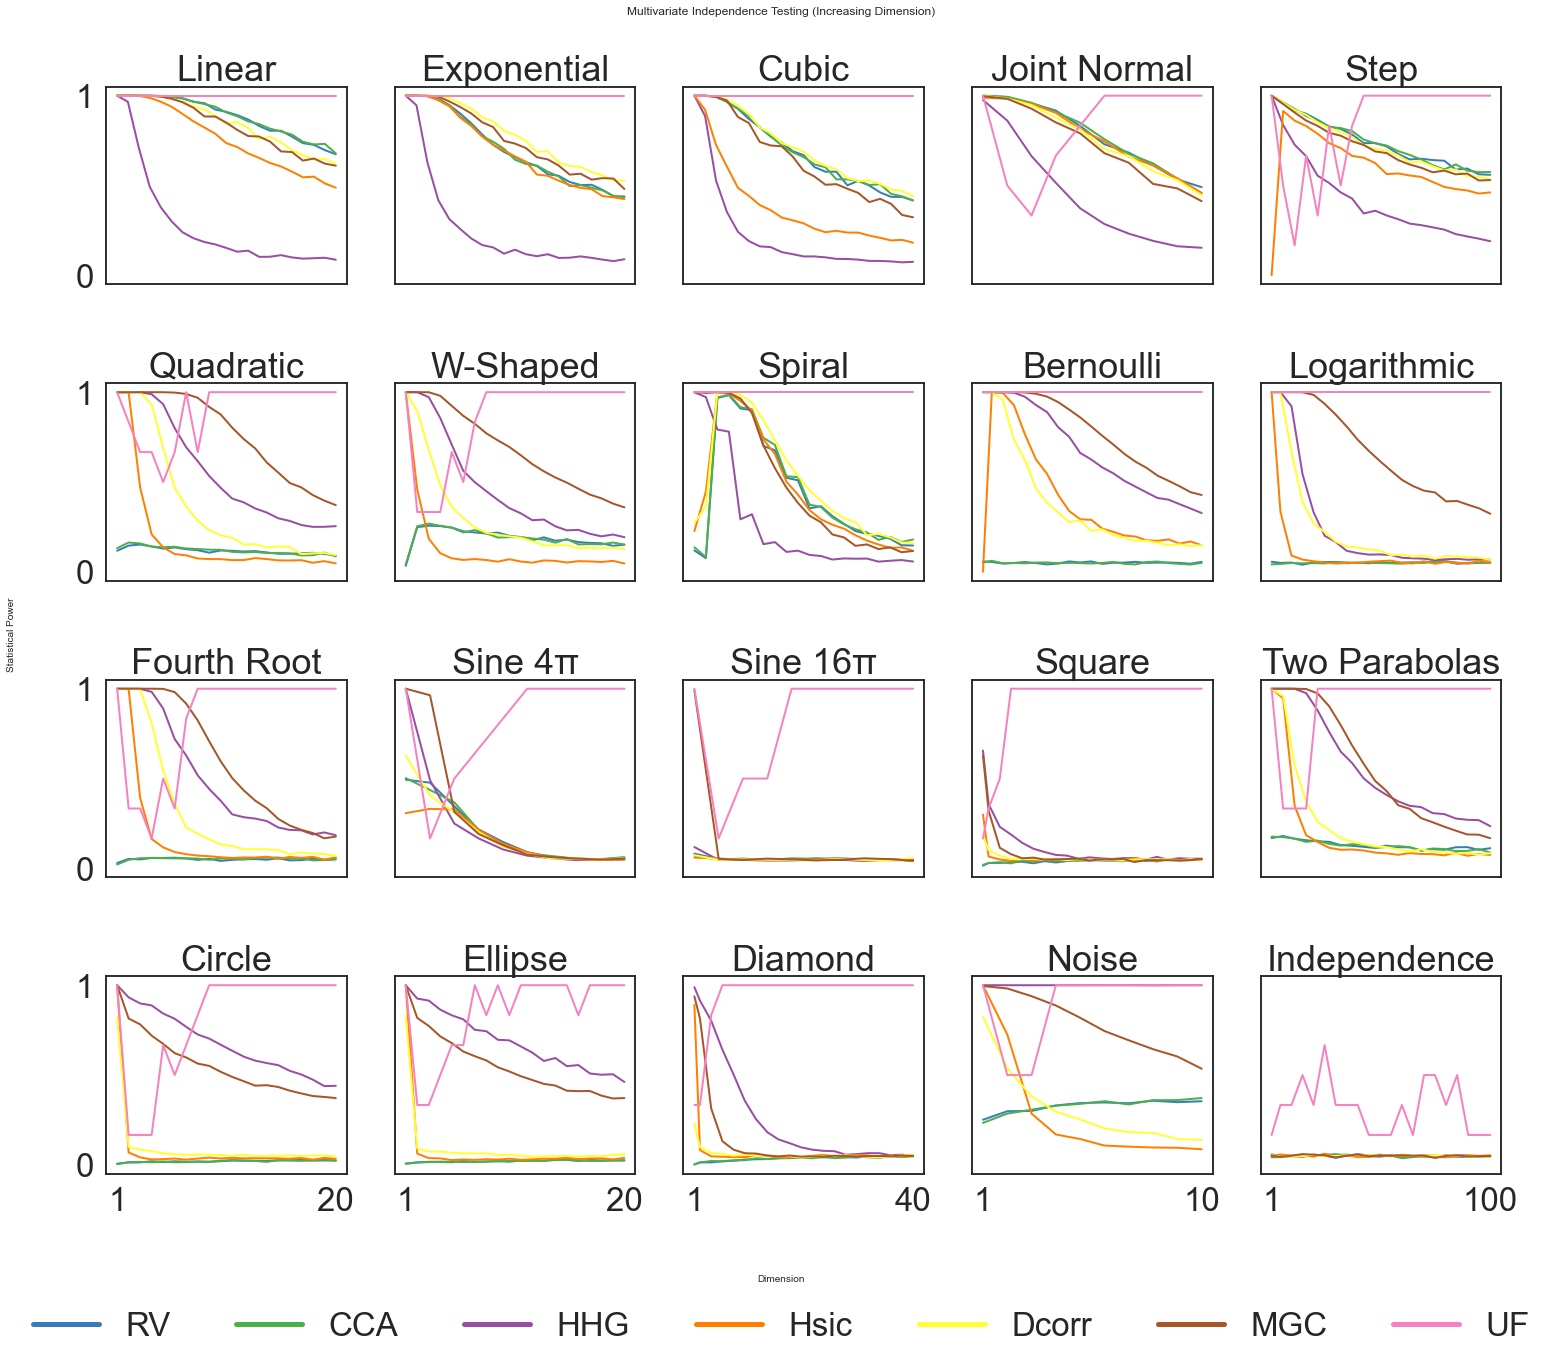

In [7]:
plot_power_all()